Pontificia Universidad Católica de Chile\
Facultad de Ingeniería\
IIC2613 - Inteligencia Artificial\
2024-2

---

<div style="text-align: center;">
  <h2>Tarea 5</h2>
  <h1>Aprendizaje Profundo</h1>
  <h2>DCChampiñones Parte II</h2>
  <p>Fecha de entrega: miércoles 27 de noviembre a las 23:59 hrs.
</div>

---

<div style="text-align: center;">
  <h3>Nombre: Vicente Antonio Lavagnino Gatica</h3>
  <h3>Número de alumno: 21638322</h3>
</div>

---

Se recomienda fuertemente realizar esta tarea en Google Colab, por motivos de rendimiento y desempeño.

### Setup librerías.
Se importan las librerías y módulos necesarios para construir, entrenar y evaluar los modelos. Estas librerías incluyen procesamiento de imágenes, arquitecturas de redes neuronales, métricas de clasificación y visualización de datos.

In [76]:
import os
import numpy as np
import random

# Módulos de TensorFlow y Keras para modelos preentrenados y procesamiento de imágenes
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

# Módulos de Scikit-Learn para modelos y evaluación
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Visualización de datos
import matplotlib.pyplot as plt
import seaborn as sns

# Barra de progreso
from tqdm import tqdm

**IMPORTANTE**: estas son las librerías permitidas para esta parte de la Tarea 4. El uso de cualquier otra librería debe ser debidamente justificado, y *puede no ser aceptado por el cuerpo docente del curso*.

### Preparación de rutas y etiquetas de datos
Este código define un directorio de datos y recorre sus subcarpetas (representando clases) para cargar las rutas de imágenes .jpg y asignar etiquetas basadas en el nombre de cada subcarpeta. Esto organiza las imágenes y etiquetas en listas image_paths y labels correspondientes.

In [ ]:
# Ejecutar si es necesario, unzip de los archivos
!unzip ../dataset/Mushrooms.zip

In [77]:
# Ruta del directorio de datos
data_dir = '../dataset/Mushrooms'

# Cargar todas las rutas de imágenes
image_paths = []
labels = []

for class_name in os.listdir(data_dir):
    class_dir = os.path.join(data_dir, class_name)
    if os.path.isdir(class_dir):
        for img_name in os.listdir(class_dir):
            if img_name.endswith('.jpg'):
                image_paths.append(os.path.join(class_dir, img_name))
                labels.append(class_name)

### Mapear y preparar datos para entrenamiento y prueba
Crearemos un diccionario que asigne un índice numérico a cada clase única en tus etiquetas. Luego, convierte cada etiqueta a su índice y divide tus datos en conjuntos de entrenamiento y prueba, manteniendo el balance de clases.

In [78]:
# Mapear nombres de clases a índices
classes = sorted(list(set(labels)))
class_indices = {cls: idx for idx, cls in enumerate(classes)}

# Convertir etiquetas a índices
labels = [class_indices[label] for label in labels]

# Dividir en conjunto de entrenamiento y prueba
train_image_paths, test_image_paths, train_labels, test_labels = train_test_split(
    image_paths, labels, test_size=0.2, random_state=42, stratify=labels
)

### Preprocesamiento de imágenes
Define el tamaño deseado para redimensionar imágenes y crea una función para cargar cada imagen, redimensionarla, normalizarla y convertirla en un vector 1D. Además, sincroniza las etiquetas con las imágenes cargadas y maneja errores en la carga.

In [79]:
# Tamaño de la imagen que vamos a utilizar
image_size = (64, 64)

# Función para convertir imágenes en vectores y sincronizar etiquetas
def preprocess_images_and_labels(image_paths, labels):
    data = []
    valid_labels = []  # Lista para guardar etiquetas válidas
    for idx, img_path in enumerate(image_paths):
        try:
            img = load_img(img_path, target_size=image_size)
            img_array = img_to_array(img) / 255.0  # Normalizar entre 0 y 1
            img_flattened = img_array.flatten()  # Convertir a un vector 1D
            data.append(img_flattened)
            
            # Agregar etiqueta solo si la imagen fue procesada correctamente
            if idx < len(labels):
                valid_labels.append(labels[idx])  # Agregar etiqueta correspondiente
        except OSError as e:
            print(f"Error cargando la imagen {img_path}: {e}")
            continue

    # Asegurarnos de que el tamaño de data y valid_labels coinciden
    if len(data) != len(valid_labels):
        print(f"Discrepancia detectada: {len(data)} imágenes y {len(valid_labels)} etiquetas.")
        if len(data) > len(valid_labels):
            data = data[:len(valid_labels)]
        elif len(valid_labels) > len(data):
            valid_labels = valid_labels[:len(data)]

    return np.array(data), valid_labels

# Preprocesar imágenes y etiquetas de entrenamiento y prueba
train_images_flat, train_labels_filtered = preprocess_images_and_labels(train_image_paths, train_labels)
test_images_flat, test_labels_filtered = preprocess_images_and_labels(test_image_paths, test_labels)


Error cargando la imagen ../dataset/Mushrooms/Russula/092_43B354vYxm8.jpg: image file is truncated (92 bytes not processed)


---

# Actividad 1: Análisis del preprocesamiento
Responde las siguientes preguntas antesde continuar:

Investiga y describe por qué el preprocesamiento es una etapa crucial para las redes neuronales.
Explica cómo los pasos de preprocesamiento pueden afectar el rendimiento de un modelo

El preprocesamiento de datos es una etapa crucial para el entrenamiento de redes neuronales, esto debido a que mejora la calidad y facilita el aprendizaje de los modelos, en particular esto es causado porque el preprocesamiento mejora la calidad de los datos, al eliminar el ruido, estandarizar los datos, normalizarlos y reducir la dimensionalidad de los datos, provocando así un entrenamiento más eficiente y efectivo.

En cuanto a como los pasos de preprocesamiento pueden afectar el rendimiento de un modelo, podemos decir que la estandarización y normalización de los datos puede mejorar el rendimiento de un modelo, ya que al tener datos en una escala similar, nos aseguramos que ciertos atributos no tengan más peso que otros. A su vez, la reducción de ruido ayuda a evitar que el modelo aprenda de datos patrones incorrectos, y la reducción de dimensionalidad ayuda a generar mayor eficiencia en el entrenamiento, ya que se reducen los tiempos de entrenamiento y se evita el overfitting Por otra parte, el aumento de datos mejora la capacidad del modelo para manejar la variabilidad de los datos, y el balanceo de clases ayuda a que el modelo no se sesgue hacia una clase en particular que pueda ser mayoritaria en los datos.

Muestra un gráfico de la distribución de imágenes y muestra una imagen por clase.

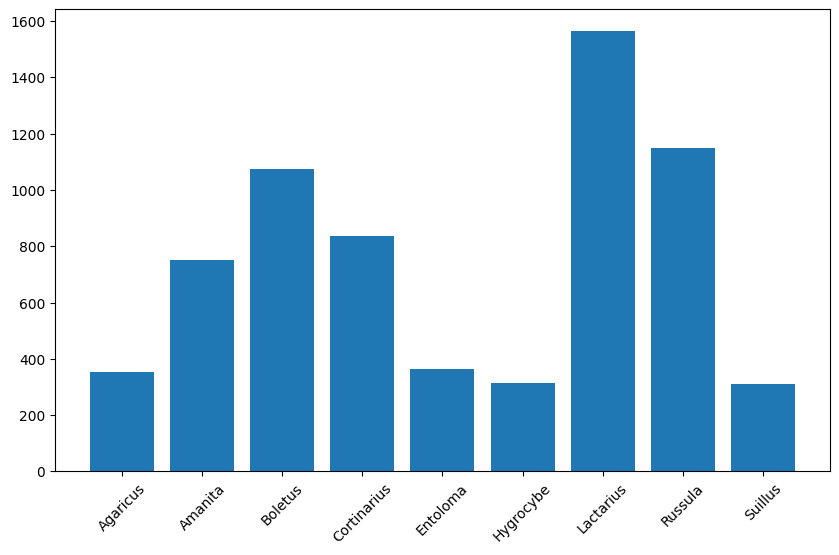

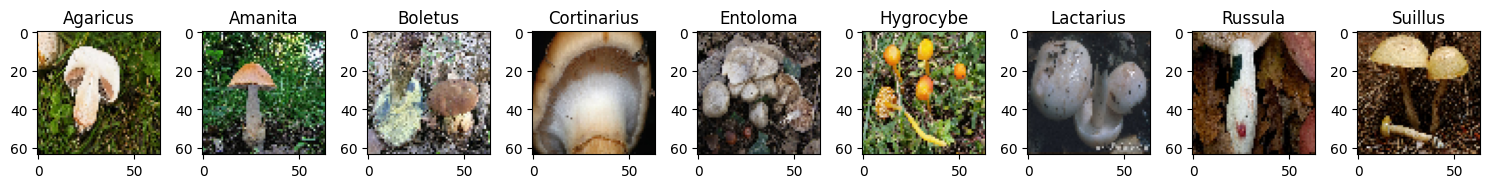

In [80]:
# TO DO:

# Código generado personalmente con recomendaciones de Copilot.

# Contar la cantidad de imágenes por clase
class_counts = [labels.count(cls) for cls in range(len(classes))]

# Gráfico de barras
plt.figure(figsize=(10, 6))
plt.bar(range(len(unique_classes)), class_counts)
plt.xticks(ticks=range(len(unique_classes)), labels=classes, rotation=45)
plt.show()

# Mostrar una imagen por clase
fig, axes = plt.subplots(1, len(unique_classes), figsize=(15, 5))
for idx, cls in enumerate(unique_classes):
    for img_path, label in zip(image_paths, labels):
        if label == cls:
            img = load_img(img_path, target_size=image_size)
            img_array = img_to_array(img) / 255.0
            axes[idx].imshow(img_array)
            axes[idx].set_title(classes[cls])
            break
plt.tight_layout()
plt.show()


Luego revisa imágenes de diferentes clases. Como podrás darte cuenta, existe una variabilidad visual entre las imágenes que pertenecen a la misma clase, es decir, dentro de una clase hay imágenes que son muy distintas entre si. Comenta acerca de como crees que esta variabilidad podría afectar al rendimiento de un modelo de inteligencia artificial que intente clasificar estas imágenes.

Podemos ver que en cada clase hay una amplia variabilidad de imágenes que comprenden diferencias en cuanto a enfoque, aumnento, luz, color, etc. 

Evidentemente todas esta diferencias de gran variabilidad afectan de gran manera al entrenamiento, produciendo que el modelo no sea capaz de generalizar correctamente, generando así una dificultad para identificar patrones únicos o consistentes entre clases y una mayor probabilidad de overfitting debido a que el modelo se fuerce a aprender de patrones que no son consistentes entre las clases.

---

# Actividad 2: Implementación y entrenamiento de una MLP

Antes de implementar la  MLP, responde las siguientes preguntas que te servirán de guía:

- Discute cómo la profundidad y el ancho (número de capas y neuronas por capa) de un MLP afectan su capacidad para aprender patrones complejos. ¿Cuáles son los desafíos relacionados con el aumento de la complejidad del modelo?

- Investiga y compara (a nivel teórico) al menos dos funciones de activación no lineales diferentes utilizadas en MLPs. ¿Cómo afectan estas funciones al tipo de decisiones que puede aprender la red? Considera aspectos como la saturación y la no linealidad.

### Número de capas y neuronas por capa

Para aprendender patrones complejos, el número de de capas y la cantidad de neuronas por capas toma un rol fundametal.

En particular, un mayor número de capas logra que el modelo pueda aprender patrones más complejos y relaciones más abstracatas (como lo puede ser el caso de la identificación con imágenes). Sumado a esto, un mayor número de capas permite que el modelo logre simular funciones más complejas, como pueder el caso de simular funciones no lineales de una manera más precisa.

Por otra parte, un mayor número de neuronas por capa permite que el modelo pueda tomar más variables a clasificar en cada capa, permitiendo que el modelo pueda aprender de una mayor cantidad de datos y patrones.

Todo esto conlleva  a su vez desafíos, modelos más profundos pueden cometer el error de sobreajustarse a los datos para problemas más simples, memorizando datos y no logrando generalizar correctamente.

Por su parte, una mayor cantidad de neuronas por capa puedem aprender reiteradamente de los mismos datos o muy similares, aumentando la redundancia de los datos.

En general debemos ser cuidadosos con aumentar estos parámetros del modelo ya que en cualquier caso un aumento conlleva a un aumento en la complejidad del modelo y por ende a un aumento en el tiempo de entrenamiento y los recursos computacionales necesarios.

### Funciones de activación no lineales

Las funciones de activación son claves para el aprendizaje de las redes neuronales, particularmente operando sobre la neurona en su salida y permitiendo que la red pueda aprender de datos no lineales (pasando de un número a un rango de valores, por ejemplo).

Dos funciones de activación no lineales comunes son la función sigmoidal y la función ReLU.

La función sigmoidal toma valores de cualquier rango en su entrada y los transforma a un rango de 0 a 1, debido a esto, su principal uso es para problemas de clasificación binaria, ya que su salida es una probabilidad. Sin embargo, esta función tiene problemas de saturación, ya que para valores muy grandes satura a 1 y para valores muy pequeños satura a 0, esto provoca que el gradiente sea muy pequeño y por ende dificulta la convergencia del algoritmo.

Otra función de activación no lineal es la función ReLU (Rectified Linear Unit), esta simplemente rectifica los datos de modo que si el valor es menor a 0, lo transforma a 0, y si es mayor a 0, lo deja igual. Esta función tiene el gran beneficio de no saturar, y por ende hya mucha mayor facilidad para que el algoritmo converja, además es matemáticamente más sencilla de calcular, lo que la hace más eficiente computacionalmente.


fuente para preguntas de funciones no lineales: https://codificandobits.com/blog/funcion-de-activacion/

### Entrenamiento de un modelo MLP utilizando las imágenes
Debes definir un modelo MLP (Perceptrón Multicapa) básico. Debes hacer al menos 3 modelos con diferentes
combinaciones de hiperparámetros. Estos deben tener como mínimo 3 capas. A continuación, debes entrenarlos utilizando las imágenes que ya han sido preprocesadas.

In [81]:
# etiquetas en formato
train_labels_filtered = np.array(train_labels_filtered)
test_labels_filtered = np.array(test_labels_filtered)

# Modelo 1
# 3 capas, 128 neuronas cada una, función de activación ReLU
modelo_1 = MLPClassifier(hidden_layer_sizes=(128, 128, 128), activation='relu', random_state=42)
modelo_1.fit(train_images_flat, train_labels_filtered)

MLPClassifier(hidden_layer_sizes=(128, 128, 128), random_state=42)

In [ ]:
# Modelo 2
# 3 capas, 256 neuronas cada una, función de activación ReLU
modelo_2 = MLPClassifier(hidden_layer_sizes=(256, 256, 256), activation='relu', random_state=42)
modelo_2.fit(train_images_flat, train_labels_filtered)

In [ ]:
# Modelo 3
# 5 capas, 256 neuronas cada una, función de activación ReLU
modelo_3 = MLPClassifier(hidden_layer_sizes=(256, 256, 256, 256, 256), activation='relu', random_state=42)
modelo_3.fit(train_images_flat, train_labels_filtered)

Evalúalos en las 4 métricas descritas en el enunciado. En base a esos resultados decide cual es el mejor de los 3 y genera su matriz de confusión. Comenta sobre esta matriz.

In [ ]:
# Reporte Modelo 1
predicciones_1 = modelo_1.predict(test_images_flat)
print("Modelo 1")
print(classification_report(test_labels_filtered, predicciones_1, target_names=classes))
print("\n")

# Reporte Modelo 2
predicciones_2 = modelo_2.predict(test_images_flat)
print("Modelo 2")
print(classification_report(test_labels_filtered, predicciones_2, target_names=classes))
print("\n")

# Reporte Modelo 3
predicciones_3 = modelo_3.predict(test_images_flat)
print("Modelo 3")
print(classification_report(test_labels_filtered, predicciones_3, target_names=classes))


In [ ]:
# Matriz de confusión Modelo 2
matriz_confusion_2 = confusion_matrix(test_labels_filtered, predicciones_2)

# Visualización de la matriz de confusión
plt.figure(figsize=(10, 8))
sns.heatmap(matriz_confusion_2, annot=True, xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicción')
plt.ylabel('Etiqueta Verdadera')
plt.show()

Por último responde a las preguntas:

Discute cómo el rendimiento de un MLP se ve afectado por el número de capas ocultas y el número de neuronas en cada capa. ¿Cuáles son las ventajas y desventajas de aumentar la complejidad de la arquitectura del MLP en términos de capacidad de aprendizaje y riesgo de overfitting?

el rendimiento de un MLP está directamente relacionado con su arquitectura, en particular con el número de capas ocultas y el número de neuronas en cada capa. 

Al incorporar más capas al MLP se permite aprender representaciones más compleja, lo que es beneficioso para problemas más complejos, sin embargo, esto naturalmeente aumenta el tiempo de convergencia del modelo y aumenta el riesgo de overfitting si el problema no es lo suficientemente complejo.

Por otro lado, al aumentar el número de neuronas en cada capa, se permite que el modelo logre capturar más variaciones de datos y analizar más parámetros, sin embargo, esto puede inducir a un sobre ajuste de los datos, ya que el modelo puede aprender de datos que no son relevantes para el problema si se usa sin fundamentación.

En general, una arquitectura más compleja puede ser provechosa para problemas complejos, pero es importante tener en cuenta que se debe balancear con tener en consideración la necesidad en el caso ya que en situaciones que no lo requieren, se puede caer en overfitting y en un tiempo de entrenamiento excesivo.

---

# Actividad 3: Implementación y entrenamiento de una CNN

Antes de la implementación investiga qué es una Red Neuronal Convolucional (CNN), y responde de manera breve las siguientes preguntas teóricas.
- ¿Qué es una operación convolucional? ¿Qué es un ``kernel``? Utiliza estos conceptos para explicar el rol de las capas convolucionales en una CNN.

- ¿Cuál es el rol de las funciones de activación? ¿Y de las capas de \textit{Max Pooling}?

- Quizás habrás notado que la mayoría de arquitecturas de CNN's utilizan una última capa conocida como ``flatten layer``. ¿Cúal es su función? ¿Cuál es el rol de la función ``softmax`` en ella?

Una operación convolutional es una operación matemática, esta se usa en el contexto de las CNN para extraer características de las imágenes. A su vez, un kernel es una matriz que establece valores (pesos) para cada pixel de la imagen, al aplicarlo lo que sucede es que se recorre la imagen con el kernel y se calcula el producto punto entre el kernel y la imagen, generando así una nueva matriz de salida, en el caso de las CNN, este proceso es útil para identificar patrones en las imágenes como bordes, texturas, formas, etc.

El rol de las funciones de activación, es inducir el componente no lineal en las redes neuronales, logrando así transformar datos de entrada en una salida no lineal con relación a el comportamiento de los datos. Esto permite que el modelo aprenda relaciones más complejas y no lineales entre los datos. Las capas de Max Pooling, se utilizan en este contexto para reducir la dimensionalidad de los datos asociados a las imágenes, esto se logra movilizando una ventana sobre la imagen y tomando el valor máximo de cada ventana, esto permite reducir el tamaño de la imagen pero mantener las características más importantes y hacerse menos suceptible a errores de pequeñas deformaciones o errores que puede contener la imagen.

La flatten layer, es una capa que se utiliza para transformar los datos de entrada en un vector unidimensional, esto es fundamentalmente para conectar de manera eficiente las distintas capas convolucionales (con distintas dimensiones). Por otra parte, la función softmax es una función de activación que se utiliza en la capa de salida para clasificar los datos en distintas clases según una función de probabilidad, este tipo de función es frecuemntemente utilizada en problemas de clasificación.

### Entrenamiento de un modelo MLP utilizando las imágenes
Ahora debes implementar una CNN utilizando el framework ``keras``. Luego investiga acerca de los hiperparámetros del modelo, y a continuación crea al menos 3 modelos con diferentes combinaciones de hiperparámetros. Estos deben tener como mínimo 3 capas convolucionales.

In [83]:
# Esta primera sección previa al modelo fue hecha junto a copilot para debuggear

# Si las etiquetas son multidimensionales, necesitas aplanarlas primero
train_labels_flattened = train_labels_filtered.reshape(-1)
test_labels_flattened = test_labels_filtered.reshape(-1)

# Convertir a categorical
train_labels_categorical = to_categorical(train_labels_flattened, num_classes=numero_clases)
test_labels_categorical = to_categorical(test_labels_flattened, num_classes=numero_clases)

# Redimensionar imágenes
train_images = train_images_flat.reshape(-1, 64, 64, 3)
test_images = test_images_flat.reshape(-1, 64, 64, 3)

# Modelo 1
modelo_1 = Sequential()
modelo_1.add(Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)))
modelo_1.add(MaxPooling2D((2, 2)))
modelo_1.add(Conv2D(32, (3, 3), activation='relu'))
modelo_1.add(MaxPooling2D((2, 2)))
modelo_1.add(Conv2D(32, (3, 3), activation='relu'))
modelo_1.add(MaxPooling2D((2, 2)))
modelo_1.add(Flatten())
modelo_1.add(Dense(128, activation='relu'))
modelo_1.add(Dense(numero_clases, activation='softmax'))

# Compilar modelo
modelo_1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenar modelo
modelo_1.fit(train_images, train_labels_categorical, epochs=10, batch_size=32, validation_data=(test_images, test_labels_categorical))

Epoch 1/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.2179 - loss: 2.0440 - val_accuracy: 0.3410 - val_loss: 1.8490
Epoch 2/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.3528 - loss: 1.8081 - val_accuracy: 0.3634 - val_loss: 1.7614
Epoch 3/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.3847 - loss: 1.7063 - val_accuracy: 0.4028 - val_loss: 1.7014
Epoch 4/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.4462 - loss: 1.5673 - val_accuracy: 0.4058 - val_loss: 1.6922
Epoch 5/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.4878 - loss: 1.4724 - val_accuracy: 0.4155 - val_loss: 1.6667
Epoch 6/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.5051 - loss: 1.4123 - val_accuracy: 0.4289 - val_loss: 1.6298
Epoch 7/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.5578 - loss: 1.2670 - val_accuracy: 0.4512 - val_loss: 1.6161
Epoch 8/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.5942 - loss: 1.1653 - val_accu

In [85]:
# Modelo 2
# 3 capas convolucionales, 64 filtros y función de activación ReLU
modelo_2 = Sequential()
modelo_2.add(Conv2D(64, (3, 3), activation='relu', input_shape=(64, 64, 3)))
modelo_2.add(MaxPooling2D((2, 2)))
modelo_2.add(Conv2D(64, (3, 3), activation='relu'))
modelo_2.add(MaxPooling2D((2, 2)))
modelo_2.add(Conv2D(64, (3, 3), activation='relu'))
modelo_2.add(MaxPooling2D((2, 2)))
modelo_2.add(Flatten())
modelo_2.add(Dense(128, activation='relu'))
modelo_2.add(Dense(numero_clases, activation='softmax'))

# Compilar modelo
modelo_2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenar modelo
modelo_2.fit(train_images, train_labels_categorical, epochs=10, batch_size=32, validation_data=(test_images, test_labels_categorical))


Epoch 1/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 7s 38ms/step - accuracy: 0.2257 - loss: 2.0411 - val_accuracy: 0.3172 - val_loss: 1.8613
Epoch 2/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - accuracy: 0.3414 - loss: 1.8007 - val_accuracy: 0.3872 - val_loss: 1.7459
Epoch 3/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - accuracy: 0.4091 - loss: 1.6451 - val_accuracy: 0.3991 - val_loss: 1.7391
Epoch 4/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - accuracy: 0.4755 - loss: 1.4776 - val_accuracy: 0.4110 - val_loss: 1.6460
Epoch 5/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - accuracy: 0.5248 - loss: 1.3348 - val_accuracy: 0.4393 - val_loss: 1.6310
Epoch 6/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - accuracy: 0.6045 - loss: 1.1434 - val_accuracy: 0.4147 - val_loss: 1.7106
Epoch 7/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - accuracy: 0.6625 - loss: 0.9508 - val_accuracy: 0.4088 - val_loss: 1.8121
Epoch 8/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - accuracy: 0.7468 - loss: 0.7451 - val_accu

In [88]:
# Modelo 3
# 5 capas convolucionales, 64 filtros y función de activación ReLU
modelo_3 = Sequential()
modelo_3.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(64, 64, 3)))
modelo_3.add(MaxPooling2D((2, 2)))
modelo_3.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
modelo_3.add(MaxPooling2D((2, 2)))
modelo_3.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
modelo_3.add(MaxPooling2D((2, 2)))
modelo_3.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
modelo_3.add(MaxPooling2D((2, 2)))
modelo_3.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
modelo_3.add(MaxPooling2D((2, 2)))
modelo_3.add(Flatten())
modelo_3.add(Dense(128, activation='relu'))
modelo_3.add(Dense(numero_clases, activation='softmax'))

# Compilar modelo
modelo_3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenar modelo
modelo_3.fit(train_images, train_labels_categorical, epochs=10, batch_size=32, validation_data=(test_images, test_labels_categorical))

Epoch 1/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.2156 - loss: 2.0646 - val_accuracy: 0.3053 - val_loss: 1.9633
Epoch 2/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - accuracy: 0.2997 - loss: 1.9058 - val_accuracy: 0.3730 - val_loss: 1.7697
Epoch 3/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - accuracy: 0.3716 - loss: 1.7528 - val_accuracy: 0.3462 - val_loss: 1.8167
Epoch 4/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.4035 - loss: 1.6573 - val_accuracy: 0.4021 - val_loss: 1.6787
Epoch 5/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - accuracy: 0.4468 - loss: 1.5495 - val_accuracy: 0.4281 - val_loss: 1.6333
Epoch 6/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - accuracy: 0.4910 - loss: 1.4375 - val_accuracy: 0.4594 - val_loss: 1.6026
Epoch 7/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.5295 - loss: 1.3180 - val_accuracy: 0.4341 - val_loss: 1.5948
Epoch 8/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.5748 - loss: 1.2301 - val_accu

Evalúalos en las 4 métricas descritas en el enunciado. En base a esos resultados decide cual es el mejor de los 3 y genera su matriz de confusión. Comenta sobre esta matriz.

In [91]:
test_labels_clases = test_labels_filtered

# Predicciones Modelo 1
predicciones_1 = modelo_1.predict(test_images)
predicciones_clases_1 = np.argmax(predicciones_1, axis=1)


reporte_1 = classification_report(test_labels_clases, predicciones_clases_1, target_names=classes)
print("Reporte de clasificación para el Modelo 1")
print(reporte_1)
print("\n")


# Predicciones Modelo 2
predicciones_2 = modelo_2.predict(test_images)
predicciones_clases_2 = np.argmax(predicciones_2, axis=1)

reporte_2 = classification_report(test_labels_clases, predicciones_clases_2, target_names=classes)
print("Reporte de clasificación para el Modelo 2")
print(reporte_2)
print("\n")

# Predicciones Modelo 3
predicciones_3 = modelo_3.predict(test_images)
predicciones_clases_3 = np.argmax(predicciones_3, axis=1)

reporte_3 = classification_report(test_labels_clases, predicciones_clases_3, target_names=classes)
print("Reporte de clasificación para el Modelo 3")
print(reporte_3)
print("\n")

42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Reporte de clasificación para el Modelo 1
              precision    recall  f1-score   support

    Agaricus       0.23      0.31      0.26        70
     Amanita       0.55      0.36      0.43       150
     Boletus       0.72      0.57      0.63       215
 Cortinarius       0.35      0.31      0.33       167
    Entoloma       0.22      0.30      0.26        73
   Hygrocybe       0.64      0.29      0.40        63
   Lactarius       0.43      0.55      0.48       313
     Russula       0.44      0.50      0.47       230
     Suillus       0.13      0.10      0.11        62

    accuracy                           0.43      1343
   macro avg       0.41      0.36      0.37      1343
weighted avg       0.46      0.43      0.43      1343



42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Reporte de clasificación para el Modelo 2
              precision    recall  f1-score   support

    Agaricus       0.24      0.14      0.18        70
     Amanita       0.

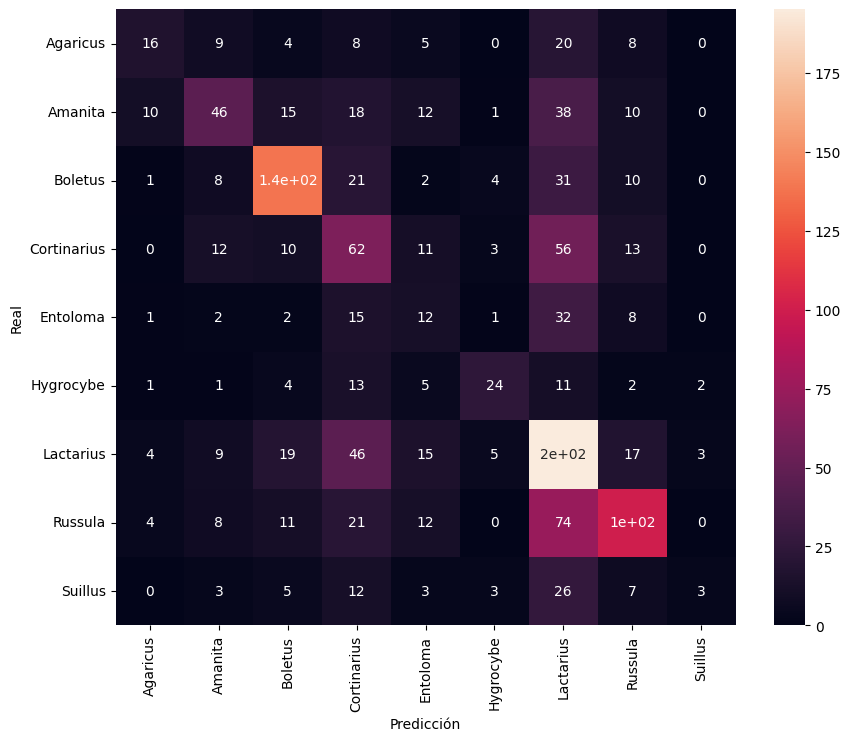

In [94]:
# Matriz confusión Modelo 3
matriz_confusion_3 = confusion_matrix(test_labels_clases, predicciones_clases_3)

# Visualizar Matriz de Confusión
plt.figure(figsize=(10, 8))
sns.heatmap(matriz_confusion_3, annot=True, xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.show()

Por último responde a las preguntas:

Discute cómo el rendimiento de un MLP se ve afectado por el número de capas ocultas y el número de neuronas en cada capa. ¿Cuáles son las ventajas y desventajas de aumentar la complejidad de la arquitectura del MLP en términos de capacidad de aprendizaje y riesgo de overfitting?

Al agregar más capas ocultas, el modelo puede aprender patrones más complejos, lo que es bueno para problemas complejos, no obstannte, naturalmente se aumenta el tiempo de convergencia y aumenta el riesgo de overfitting si el problema no es lo suficientemente complejo. 

Por otro lado, al aumentar el número de neuronas en cada capa, se permite que el modelo logre capturar más características de los datos y analizar más parámetros, sin embargo, esto puede provocar un overfitting de los datos, ya que el modelo puede aprender de datos que no son relevantes para el problema si se usa sin fundamentación, fallando así en generalizar para nuevos datos.

En particular a lo asociado a este ejercicio, el balance entre el nodos por capa y capas del modelo 1 y 3 parecen ser tentativamente mejores que aumentar los filtros sin aumentar las capas, ya que se logra un mejor rendimiento en las métricas de evaluación.

---

# Actividad 4: Utilizando embeddings de ``ResNet50``

### Código base de extracción de Embeddings con ResNet50 para clasificación de imágenes.
La siguiente celda carga el modelo ResNet50 preentrenado y define una función para extraer embeddings de imágenes en lotes, con manejo de errores y visualización del progreso. Usa esta estructura para generar embeddings de entrenamiento y prueba.

In [95]:
# Cargar el modelo ResNet50 preentrenado
resnet_model = ResNet50(weights='imagenet', include_top=False, pooling='avg')

# Función para extraer embeddings de las imágenes con progreso y manejo de errores
def extract_embeddings_batch(image_paths, model, batch_size=32):
    embeddings = []
    for i in tqdm(range(0, len(image_paths), batch_size), desc="Procesando lotes"):
        batch_paths = image_paths[i:i + batch_size]
        batch_images = []
        for img_path in batch_paths:
            try:
                img = load_img(img_path, target_size=(224, 224))
                img_array = img_to_array(img)
                img_array = preprocess_input(np.expand_dims(img_array, axis=0))
                batch_images.append(img_array)
            except OSError as e:
                print(f"Error cargando la imagen {img_path}: {e}")
                continue  # Ignora esta imagen y continúa con las demás
        
        # Verifica si hay imágenes válidas en el lote antes de procesar
        if batch_images:
            batch_images = np.vstack(batch_images)
            batch_embeddings = model.predict(batch_images)
            embeddings.extend(batch_embeddings)
    return np.array(embeddings)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 26s 0us/step


In [96]:
# Extraer embeddings usando la función de batches
train_embeddings = extract_embeddings_batch(train_image_paths, resnet_model, batch_size=8)
test_embeddings = extract_embeddings_batch(test_image_paths, resnet_model, batch_size=8)

Procesando lotes:   0%|          | 0/672 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 666ms/step


Procesando lotes:   0%|          | 1/672 [00:00<08:01,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


Procesando lotes:   0%|          | 2/672 [00:00<04:38,  2.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Procesando lotes:   0%|          | 3/672 [00:01<03:30,  3.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Procesando lotes:   1%|          | 4/672 [00:01<02:58,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Procesando lotes:   1%|          | 5/672 [00:01<02:40,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Procesando lotes:   1%|          | 6/672 [00:01<02:30,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


Procesando lotes:   1%|          | 7/672 [00:01<02:24,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Procesando lotes:   1%|          | 8/672 [00:02<02:20,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Procesando lotes:   1%|▏         | 9/672 [00:02<02:15,  4.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Procesando lotes:   1%|▏         | 10/672 [00:02<02:13,  4.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Procesando lotes:   2%|▏         | 11/672 [00:02<02:18,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Procesando lotes:   2%|▏         | 12/672 [00:02<02:14,  4.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Procesando lotes:   2%|▏         | 13/672 [00:03<02:11,  5.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Procesando lotes:   2%|▏         | 14/672 [00:03<02:09,  5.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Procesando lotes:   2%|▏         | 15/672 [00:03<02:08,  5.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


Procesando lotes:   2%|▏         | 16/672 [00:03<02:10,  5.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


Procesando lotes:   3%|▎         | 17/672 [00:03<02:13,  4.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Procesando lotes:   3%|▎         | 18/672 [00:04<02:11,  4.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Procesando lotes:   3%|▎         | 19/672 [00:04<02:10,  5.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


Procesando lotes:   3%|▎         | 20/672 [00:04<02:11,  4.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


Procesando lotes:   3%|▎         | 21/672 [00:04<02:12,  4.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Procesando lotes:   3%|▎         | 22/672 [00:04<02:10,  4.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Procesando lotes:   3%|▎         | 23/672 [00:05<02:14,  4.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Procesando lotes:   4%|▎         | 24/672 [00:05<02:12,  4.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Procesando lotes:   4%|▎         | 25/672 [00:05<02:15,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


Procesando lotes:   4%|▍         | 26/672 [00:05<02:13,  4.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Procesando lotes:   4%|▍         | 27/672 [00:05<02:11,  4.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


Procesando lotes:   4%|▍         | 28/672 [00:06<02:10,  4.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


Procesando lotes:   4%|▍         | 29/672 [00:06<02:10,  4.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Procesando lotes:   4%|▍         | 30/672 [00:06<02:08,  5.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Procesando lotes:   5%|▍         | 31/672 [00:06<02:06,  5.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Procesando lotes:   5%|▍         | 32/672 [00:06<02:06,  5.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


Procesando lotes:   5%|▍         | 33/672 [00:07<02:07,  5.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


Procesando lotes:   5%|▌         | 34/672 [00:07<02:10,  4.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Procesando lotes:   5%|▌         | 35/672 [00:07<02:13,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Procesando lotes:   5%|▌         | 36/672 [00:07<02:09,  4.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Procesando lotes:   6%|▌         | 37/672 [00:07<02:07,  4.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Procesando lotes:   6%|▌         | 38/672 [00:08<02:05,  5.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


Procesando lotes:   6%|▌         | 39/672 [00:08<02:07,  4.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


Procesando lotes:   6%|▌         | 40/672 [00:08<02:08,  4.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


Procesando lotes:   6%|▌         | 41/672 [00:08<02:10,  4.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Procesando lotes:   6%|▋         | 42/672 [00:08<02:13,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


Procesando lotes:   6%|▋         | 43/672 [00:09<02:16,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


Procesando lotes:   7%|▋         | 44/672 [00:09<02:12,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Procesando lotes:   7%|▋         | 45/672 [00:09<02:09,  4.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Procesando lotes:   7%|▋         | 46/672 [00:09<02:06,  4.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Procesando lotes:   7%|▋         | 47/672 [00:10<02:04,  5.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Procesando lotes:   7%|▋         | 48/672 [00:10<02:02,  5.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


Procesando lotes:   7%|▋         | 49/672 [00:10<02:02,  5.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


Procesando lotes:   7%|▋         | 50/672 [00:10<02:09,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


Procesando lotes:   8%|▊         | 51/672 [00:10<02:14,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Procesando lotes:   8%|▊         | 52/672 [00:11<02:09,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


Procesando lotes:   8%|▊         | 53/672 [00:11<02:08,  4.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Procesando lotes:   8%|▊         | 54/672 [00:11<02:11,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


Procesando lotes:   8%|▊         | 55/672 [00:11<02:09,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


Procesando lotes:   8%|▊         | 56/672 [00:11<02:08,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Procesando lotes:   8%|▊         | 57/672 [00:12<02:13,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


Procesando lotes:   9%|▊         | 58/672 [00:12<02:12,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Procesando lotes:   9%|▉         | 59/672 [00:12<02:09,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Procesando lotes:   9%|▉         | 60/672 [00:12<02:11,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


Procesando lotes:   9%|▉         | 61/672 [00:12<02:09,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


Procesando lotes:   9%|▉         | 62/672 [00:13<02:13,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


Procesando lotes:   9%|▉         | 63/672 [00:13<02:16,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


Procesando lotes:  10%|▉         | 64/672 [00:13<02:17,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


Procesando lotes:  10%|▉         | 65/672 [00:13<02:15,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


Procesando lotes:  10%|▉         | 66/672 [00:14<02:17,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Procesando lotes:  10%|▉         | 67/672 [00:14<02:11,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Procesando lotes:  10%|█         | 68/672 [00:14<02:06,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Procesando lotes:  10%|█         | 69/672 [00:14<02:03,  4.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


Procesando lotes:  10%|█         | 70/672 [00:14<02:06,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Procesando lotes:  11%|█         | 71/672 [00:15<02:09,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Procesando lotes:  11%|█         | 72/672 [00:15<02:04,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


Procesando lotes:  11%|█         | 73/672 [00:15<02:06,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


Procesando lotes:  11%|█         | 74/672 [00:15<02:04,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Procesando lotes:  11%|█         | 75/672 [00:15<02:02,  4.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Procesando lotes:  11%|█▏        | 76/672 [00:16<02:00,  4.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


Procesando lotes:  11%|█▏        | 77/672 [00:16<02:05,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


Procesando lotes:  12%|█▏        | 78/672 [00:16<02:03,  4.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


Procesando lotes:  12%|█▏        | 79/672 [00:16<02:01,  4.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


Procesando lotes:  12%|█▏        | 80/672 [00:16<02:02,  4.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


Procesando lotes:  12%|█▏        | 81/672 [00:17<02:00,  4.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


Procesando lotes:  12%|█▏        | 82/672 [00:17<01:59,  4.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Procesando lotes:  12%|█▏        | 83/672 [00:17<01:57,  5.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Procesando lotes:  12%|█▎        | 84/672 [00:17<01:55,  5.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Procesando lotes:  13%|█▎        | 85/672 [00:17<01:54,  5.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Procesando lotes:  13%|█▎        | 86/672 [00:18<01:54,  5.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Procesando lotes:  13%|█▎        | 87/672 [00:18<01:53,  5.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Procesando lotes:  13%|█▎        | 88/672 [00:18<01:51,  5.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Procesando lotes:  13%|█▎        | 89/672 [00:18<01:52,  5.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Procesando lotes:  13%|█▎        | 90/672 [00:18<01:51,  5.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Procesando lotes:  14%|█▎        | 91/672 [00:19<01:51,  5.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Procesando lotes:  14%|█▎        | 92/672 [00:19<01:51,  5.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Procesando lotes:  14%|█▍        | 93/672 [00:19<01:50,  5.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Procesando lotes:  14%|█▍        | 94/672 [00:19<01:50,  5.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Procesando lotes:  14%|█▍        | 95/672 [00:19<01:49,  5.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Procesando lotes:  14%|█▍        | 96/672 [00:20<01:49,  5.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Procesando lotes:  14%|█▍        | 97/672 [00:20<01:49,  5.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Procesando lotes:  15%|█▍        | 98/672 [00:20<01:49,  5.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Procesando lotes:  15%|█▍        | 99/672 [00:20<01:48,  5.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Procesando lotes:  15%|█▍        | 100/672 [00:20<01:49,  5.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Procesando lotes:  15%|█▌        | 101/672 [00:21<01:49,  5.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Procesando lotes:  15%|█▌        | 102/672 [00:21<01:48,  5.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Procesando lotes:  15%|█▌        | 103/672 [00:21<01:48,  5.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Procesando lotes:  15%|█▌        | 104/672 [00:21<01:48,  5.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Procesando lotes:  16%|█▌        | 105/672 [00:21<01:48,  5.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Procesando lotes:  16%|█▌        | 106/672 [00:21<01:47,  5.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Procesando lotes:  16%|█▌        | 107/672 [00:22<01:48,  5.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Procesando lotes:  16%|█▌        | 108/672 [00:22<01:47,  5.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Procesando lotes:  16%|█▌        | 109/672 [00:22<01:47,  5.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Procesando lotes:  16%|█▋        | 110/672 [00:22<01:47,  5.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Procesando lotes:  17%|█▋        | 111/672 [00:22<01:47,  5.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Procesando lotes:  17%|█▋        | 112/672 [00:23<01:46,  5.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Procesando lotes:  17%|█▋        | 113/672 [00:23<01:46,  5.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Procesando lotes:  17%|█▋        | 114/672 [00:23<01:47,  5.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


Procesando lotes:  17%|█▋        | 115/672 [00:23<01:46,  5.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Procesando lotes:  17%|█▋        | 116/672 [00:23<01:45,  5.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Procesando lotes:  17%|█▋        | 117/672 [00:24<01:46,  5.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Procesando lotes:  18%|█▊        | 118/672 [00:24<01:46,  5.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Procesando lotes:  18%|█▊        | 119/672 [00:24<01:46,  5.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Procesando lotes:  18%|█▊        | 120/672 [00:24<01:50,  5.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Procesando lotes:  18%|█▊        | 121/672 [00:24<01:49,  5.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Procesando lotes:  18%|█▊        | 122/672 [00:25<01:48,  5.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Procesando lotes:  18%|█▊        | 123/672 [00:25<01:47,  5.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Procesando lotes:  18%|█▊        | 124/672 [00:25<01:45,  5.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Procesando lotes:  19%|█▊        | 125/672 [00:25<01:45,  5.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Procesando lotes:  19%|█▉        | 126/672 [00:25<01:45,  5.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Procesando lotes:  19%|█▉        | 127/672 [00:26<01:44,  5.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Procesando lotes:  19%|█▉        | 128/672 [00:26<01:44,  5.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Procesando lotes:  19%|█▉        | 129/672 [00:26<01:43,  5.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Procesando lotes:  19%|█▉        | 130/672 [00:26<01:43,  5.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Procesando lotes:  19%|█▉        | 131/672 [00:26<01:43,  5.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Procesando lotes:  20%|█▉        | 132/672 [00:26<01:42,  5.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Procesando lotes:  20%|█▉        | 133/672 [00:27<01:42,  5.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Procesando lotes:  20%|█▉        | 134/672 [00:27<01:42,  5.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Procesando lotes:  20%|██        | 135/672 [00:27<01:42,  5.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


Procesando lotes:  20%|██        | 136/672 [00:27<01:41,  5.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Procesando lotes:  20%|██        | 137/672 [00:27<01:41,  5.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Procesando lotes:  21%|██        | 138/672 [00:28<01:40,  5.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Procesando lotes:  21%|██        | 139/672 [00:28<01:41,  5.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Procesando lotes:  21%|██        | 140/672 [00:28<01:40,  5.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Procesando lotes:  21%|██        | 141/672 [00:28<01:41,  5.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Procesando lotes:  21%|██        | 142/672 [00:28<01:40,  5.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Procesando lotes:  21%|██▏       | 143/672 [00:29<01:40,  5.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Procesando lotes:  21%|██▏       | 144/672 [00:29<01:39,  5.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Procesando lotes:  22%|██▏       | 145/672 [00:29<01:40,  5.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


Procesando lotes:  22%|██▏       | 146/672 [00:29<01:41,  5.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


Procesando lotes:  22%|██▏       | 147/672 [00:29<01:41,  5.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Procesando lotes:  22%|██▏       | 148/672 [00:30<01:41,  5.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Procesando lotes:  22%|██▏       | 149/672 [00:30<01:41,  5.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Procesando lotes:  22%|██▏       | 150/672 [00:30<01:40,  5.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Procesando lotes:  22%|██▏       | 151/672 [00:30<01:50,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Procesando lotes:  23%|██▎       | 152/672 [00:30<01:48,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Procesando lotes:  23%|██▎       | 153/672 [00:31<01:44,  4.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Procesando lotes:  23%|██▎       | 154/672 [00:31<01:41,  5.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Procesando lotes:  23%|██▎       | 155/672 [00:31<01:40,  5.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Procesando lotes:  23%|██▎       | 156/672 [00:31<01:38,  5.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Procesando lotes:  23%|██▎       | 157/672 [00:31<01:38,  5.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Procesando lotes:  24%|██▎       | 158/672 [00:31<01:37,  5.25it/s]

Error cargando la imagen ../dataset/Mushrooms/Russula/092_43B354vYxm8.jpg: image file is truncated (92 bytes not processed)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 640ms/step


Procesando lotes:  24%|██▎       | 159/672 [00:32<02:51,  2.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Procesando lotes:  24%|██▍       | 160/672 [00:32<02:29,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Procesando lotes:  24%|██▍       | 161/672 [00:33<02:14,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


Procesando lotes:  24%|██▍       | 162/672 [00:33<02:02,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Procesando lotes:  24%|██▍       | 163/672 [00:33<01:55,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


Procesando lotes:  24%|██▍       | 164/672 [00:33<01:52,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step


Procesando lotes:  25%|██▍       | 165/672 [00:33<02:05,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


Procesando lotes:  25%|██▍       | 166/672 [00:34<01:58,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Procesando lotes:  25%|██▍       | 167/672 [00:34<01:52,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Procesando lotes:  25%|██▌       | 168/672 [00:34<01:52,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Procesando lotes:  25%|██▌       | 169/672 [00:34<01:52,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


Procesando lotes:  25%|██▌       | 170/672 [00:35<01:53,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


Procesando lotes:  25%|██▌       | 171/672 [00:35<01:51,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


Procesando lotes:  26%|██▌       | 172/672 [00:35<01:48,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


Procesando lotes:  26%|██▌       | 173/672 [00:35<01:51,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


Procesando lotes:  26%|██▌       | 174/672 [00:35<01:50,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Procesando lotes:  26%|██▌       | 175/672 [00:36<01:45,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


Procesando lotes:  26%|██▌       | 176/672 [00:36<01:45,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


Procesando lotes:  26%|██▋       | 177/672 [00:36<01:46,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


Procesando lotes:  26%|██▋       | 178/672 [00:36<01:48,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


Procesando lotes:  27%|██▋       | 179/672 [00:37<01:56,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


Procesando lotes:  27%|██▋       | 180/672 [00:37<01:52,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


Procesando lotes:  27%|██▋       | 181/672 [00:37<01:47,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Procesando lotes:  27%|██▋       | 182/672 [00:37<01:43,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Procesando lotes:  27%|██▋       | 183/672 [00:37<01:40,  4.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Procesando lotes:  27%|██▋       | 184/672 [00:38<01:39,  4.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


Procesando lotes:  28%|██▊       | 185/672 [00:38<01:40,  4.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Procesando lotes:  28%|██▊       | 186/672 [00:38<01:37,  4.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Procesando lotes:  28%|██▊       | 187/672 [00:38<01:37,  4.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Procesando lotes:  28%|██▊       | 188/672 [00:38<01:36,  5.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


Procesando lotes:  28%|██▊       | 189/672 [00:39<01:35,  5.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


Procesando lotes:  28%|██▊       | 190/672 [00:39<01:35,  5.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


Procesando lotes:  28%|██▊       | 191/672 [00:39<01:37,  4.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


Procesando lotes:  29%|██▊       | 192/672 [00:39<01:44,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


Procesando lotes:  29%|██▊       | 193/672 [00:39<01:41,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


Procesando lotes:  29%|██▉       | 194/672 [00:40<01:45,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Procesando lotes:  29%|██▉       | 195/672 [00:40<01:45,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


Procesando lotes:  29%|██▉       | 196/672 [00:40<01:44,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


Procesando lotes:  29%|██▉       | 197/672 [00:40<01:43,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


Procesando lotes:  29%|██▉       | 198/672 [00:40<01:42,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Procesando lotes:  30%|██▉       | 199/672 [00:41<01:42,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


Procesando lotes:  30%|██▉       | 200/672 [00:41<01:42,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


Procesando lotes:  30%|██▉       | 201/672 [00:41<01:42,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


Procesando lotes:  30%|███       | 202/672 [00:41<01:41,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


Procesando lotes:  30%|███       | 203/672 [00:42<01:41,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


Procesando lotes:  30%|███       | 204/672 [00:42<01:41,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


Procesando lotes:  31%|███       | 205/672 [00:42<01:41,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


Procesando lotes:  31%|███       | 206/672 [00:42<01:40,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Procesando lotes:  31%|███       | 207/672 [00:42<01:42,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Procesando lotes:  31%|███       | 208/672 [00:43<01:42,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


Procesando lotes:  31%|███       | 209/672 [00:43<01:42,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Procesando lotes:  31%|███▏      | 210/672 [00:43<01:42,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Procesando lotes:  31%|███▏      | 211/672 [00:43<01:43,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


Procesando lotes:  32%|███▏      | 212/672 [00:44<01:42,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


Procesando lotes:  32%|███▏      | 213/672 [00:44<01:42,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Procesando lotes:  32%|███▏      | 214/672 [00:44<01:38,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Procesando lotes:  32%|███▏      | 215/672 [00:44<01:35,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Procesando lotes:  32%|███▏      | 216/672 [00:44<01:32,  4.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Procesando lotes:  32%|███▏      | 217/672 [00:45<01:32,  4.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Procesando lotes:  32%|███▏      | 218/672 [00:45<01:31,  4.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Procesando lotes:  33%|███▎      | 219/672 [00:45<01:30,  4.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Procesando lotes:  33%|███▎      | 220/672 [00:45<01:33,  4.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


Procesando lotes:  33%|███▎      | 221/672 [00:45<01:34,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


Procesando lotes:  33%|███▎      | 222/672 [00:46<01:35,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Procesando lotes:  33%|███▎      | 223/672 [00:46<01:36,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


Procesando lotes:  33%|███▎      | 224/672 [00:46<01:37,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


Procesando lotes:  33%|███▎      | 225/672 [00:46<01:36,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


Procesando lotes:  34%|███▎      | 226/672 [00:46<01:35,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


Procesando lotes:  34%|███▍      | 227/672 [00:47<01:35,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


Procesando lotes:  34%|███▍      | 228/672 [00:47<01:34,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


Procesando lotes:  34%|███▍      | 229/672 [00:47<01:34,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Procesando lotes:  34%|███▍      | 230/672 [00:47<01:35,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


Procesando lotes:  34%|███▍      | 231/672 [00:48<01:35,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


Procesando lotes:  35%|███▍      | 232/672 [00:48<01:35,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Procesando lotes:  35%|███▍      | 233/672 [00:48<01:40,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


Procesando lotes:  35%|███▍      | 234/672 [00:48<01:38,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


Procesando lotes:  35%|███▍      | 235/672 [00:48<01:36,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Procesando lotes:  35%|███▌      | 236/672 [00:49<01:33,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Procesando lotes:  35%|███▌      | 237/672 [00:49<01:31,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


Procesando lotes:  35%|███▌      | 238/672 [00:49<01:29,  4.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Procesando lotes:  36%|███▌      | 239/672 [00:49<01:28,  4.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


Procesando lotes:  36%|███▌      | 240/672 [00:49<01:28,  4.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Procesando lotes:  36%|███▌      | 241/672 [00:50<01:26,  4.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


Procesando lotes:  36%|███▌      | 242/672 [00:50<01:26,  4.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


Procesando lotes:  36%|███▌      | 243/672 [00:50<01:28,  4.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


Procesando lotes:  36%|███▋      | 244/672 [00:50<01:30,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


Procesando lotes:  36%|███▋      | 245/672 [00:51<01:32,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


Procesando lotes:  37%|███▋      | 246/672 [00:51<01:35,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step


Procesando lotes:  37%|███▋      | 247/672 [00:51<01:43,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


Procesando lotes:  37%|███▋      | 248/672 [00:51<01:42,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


Procesando lotes:  37%|███▋      | 249/672 [00:52<01:39,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


Procesando lotes:  37%|███▋      | 250/672 [00:52<01:36,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


Procesando lotes:  37%|███▋      | 251/672 [00:52<01:33,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Procesando lotes:  38%|███▊      | 252/672 [00:52<01:29,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


Procesando lotes:  38%|███▊      | 253/672 [00:52<01:27,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Procesando lotes:  38%|███▊      | 254/672 [00:53<01:24,  4.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Procesando lotes:  38%|███▊      | 255/672 [00:53<01:23,  4.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Procesando lotes:  38%|███▊      | 256/672 [00:53<01:22,  5.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


Procesando lotes:  38%|███▊      | 257/672 [00:53<01:22,  5.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


Procesando lotes:  38%|███▊      | 258/672 [00:53<01:22,  5.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Procesando lotes:  39%|███▊      | 259/672 [00:54<01:21,  5.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Procesando lotes:  39%|███▊      | 260/672 [00:54<01:21,  5.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


Procesando lotes:  39%|███▉      | 261/672 [00:54<01:24,  4.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


Procesando lotes:  39%|███▉      | 262/672 [00:54<01:23,  4.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


Procesando lotes:  39%|███▉      | 263/672 [00:54<01:22,  4.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


Procesando lotes:  39%|███▉      | 264/672 [00:55<01:22,  4.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


Procesando lotes:  39%|███▉      | 265/672 [00:55<01:21,  4.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


Procesando lotes:  40%|███▉      | 266/672 [00:55<01:21,  5.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


Procesando lotes:  40%|███▉      | 267/672 [00:55<01:21,  5.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


Procesando lotes:  40%|███▉      | 268/672 [00:55<01:20,  5.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Procesando lotes:  40%|████      | 269/672 [00:56<01:20,  5.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Procesando lotes:  40%|████      | 270/672 [00:56<01:19,  5.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Procesando lotes:  40%|████      | 271/672 [00:56<01:18,  5.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Procesando lotes:  40%|████      | 272/672 [00:56<01:18,  5.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Procesando lotes:  41%|████      | 273/672 [00:56<01:17,  5.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


Procesando lotes:  41%|████      | 274/672 [00:56<01:17,  5.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Procesando lotes:  41%|████      | 275/672 [00:57<01:17,  5.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Procesando lotes:  41%|████      | 276/672 [00:57<01:17,  5.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Procesando lotes:  41%|████      | 277/672 [00:57<01:17,  5.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


Procesando lotes:  41%|████▏     | 278/672 [00:57<01:16,  5.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


Procesando lotes:  42%|████▏     | 279/672 [00:58<01:20,  4.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Procesando lotes:  42%|████▏     | 280/672 [00:58<01:19,  4.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Procesando lotes:  42%|████▏     | 281/672 [00:58<01:18,  4.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


Procesando lotes:  42%|████▏     | 282/672 [00:58<01:18,  4.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Procesando lotes:  42%|████▏     | 283/672 [00:58<01:16,  5.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


Procesando lotes:  42%|████▏     | 284/672 [00:58<01:16,  5.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Procesando lotes:  42%|████▏     | 285/672 [00:59<01:16,  5.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Procesando lotes:  43%|████▎     | 286/672 [00:59<01:16,  5.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


Procesando lotes:  43%|████▎     | 287/672 [00:59<01:15,  5.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


Procesando lotes:  43%|████▎     | 288/672 [00:59<01:17,  4.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


Procesando lotes:  43%|████▎     | 289/672 [01:00<01:18,  4.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


Procesando lotes:  43%|████▎     | 290/672 [01:00<01:18,  4.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


Procesando lotes:  43%|████▎     | 291/672 [01:00<01:19,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


Procesando lotes:  43%|████▎     | 292/672 [01:00<01:18,  4.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


Procesando lotes:  44%|████▎     | 293/672 [01:00<01:18,  4.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Procesando lotes:  44%|████▍     | 294/672 [01:01<01:17,  4.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


Procesando lotes:  44%|████▍     | 295/672 [01:01<01:17,  4.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


Procesando lotes:  44%|████▍     | 296/672 [01:01<01:16,  4.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


Procesando lotes:  44%|████▍     | 297/672 [01:01<01:16,  4.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Procesando lotes:  44%|████▍     | 298/672 [01:01<01:15,  4.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Procesando lotes:  44%|████▍     | 299/672 [01:02<01:13,  5.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Procesando lotes:  45%|████▍     | 300/672 [01:02<01:20,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Procesando lotes:  45%|████▍     | 301/672 [01:02<01:22,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Procesando lotes:  45%|████▍     | 302/672 [01:02<01:19,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


Procesando lotes:  45%|████▌     | 303/672 [01:02<01:17,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Procesando lotes:  45%|████▌     | 304/672 [01:03<01:15,  4.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Procesando lotes:  45%|████▌     | 305/672 [01:03<01:13,  5.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Procesando lotes:  46%|████▌     | 306/672 [01:03<01:12,  5.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Procesando lotes:  46%|████▌     | 307/672 [01:03<01:11,  5.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


Procesando lotes:  46%|████▌     | 308/672 [01:03<01:12,  5.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Procesando lotes:  46%|████▌     | 309/672 [01:04<01:11,  5.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


Procesando lotes:  46%|████▌     | 310/672 [01:04<01:10,  5.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


Procesando lotes:  46%|████▋     | 311/672 [01:04<01:12,  5.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


Procesando lotes:  46%|████▋     | 312/672 [01:04<01:12,  4.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


Procesando lotes:  47%|████▋     | 313/672 [01:04<01:11,  5.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


Procesando lotes:  47%|████▋     | 314/672 [01:05<01:11,  5.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


Procesando lotes:  47%|████▋     | 315/672 [01:05<01:10,  5.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


Procesando lotes:  47%|████▋     | 316/672 [01:05<01:14,  4.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


Procesando lotes:  47%|████▋     | 317/672 [01:05<01:12,  4.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


Procesando lotes:  47%|████▋     | 318/672 [01:05<01:12,  4.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Procesando lotes:  47%|████▋     | 319/672 [01:06<01:16,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Procesando lotes:  48%|████▊     | 320/672 [01:06<01:13,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


Procesando lotes:  48%|████▊     | 321/672 [01:06<01:13,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Procesando lotes:  48%|████▊     | 322/672 [01:06<01:11,  4.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Procesando lotes:  48%|████▊     | 323/672 [01:06<01:09,  5.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


Procesando lotes:  48%|████▊     | 324/672 [01:07<01:09,  4.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


Procesando lotes:  48%|████▊     | 325/672 [01:07<01:09,  5.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Procesando lotes:  49%|████▊     | 326/672 [01:07<01:08,  5.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


Procesando lotes:  49%|████▊     | 327/672 [01:07<01:08,  5.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


Procesando lotes:  49%|████▉     | 328/672 [01:07<01:08,  5.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


Procesando lotes:  49%|████▉     | 329/672 [01:08<01:08,  5.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Procesando lotes:  49%|████▉     | 330/672 [01:08<01:07,  5.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


Procesando lotes:  49%|████▉     | 331/672 [01:08<01:07,  5.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Procesando lotes:  49%|████▉     | 332/672 [01:08<01:07,  5.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


Procesando lotes:  50%|████▉     | 333/672 [01:08<01:07,  5.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


Procesando lotes:  50%|████▉     | 334/672 [01:09<01:08,  4.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


Procesando lotes:  50%|████▉     | 335/672 [01:09<01:09,  4.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


Procesando lotes:  50%|█████     | 336/672 [01:09<01:09,  4.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


Procesando lotes:  50%|█████     | 337/672 [01:09<01:08,  4.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


Procesando lotes:  50%|█████     | 338/672 [01:09<01:08,  4.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


Procesando lotes:  50%|█████     | 339/672 [01:10<01:08,  4.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


Procesando lotes:  51%|█████     | 340/672 [01:10<01:10,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


Procesando lotes:  51%|█████     | 341/672 [01:10<01:10,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


Procesando lotes:  51%|█████     | 342/672 [01:10<01:08,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


Procesando lotes:  51%|█████     | 343/672 [01:11<01:07,  4.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Procesando lotes:  51%|█████     | 344/672 [01:11<01:05,  4.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


Procesando lotes:  51%|█████▏    | 345/672 [01:11<01:04,  5.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


Procesando lotes:  51%|█████▏    | 346/672 [01:11<01:04,  5.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Procesando lotes:  52%|█████▏    | 347/672 [01:11<01:04,  5.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Procesando lotes:  52%|█████▏    | 348/672 [01:11<01:04,  5.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Procesando lotes:  52%|█████▏    | 349/672 [01:12<01:03,  5.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


Procesando lotes:  52%|█████▏    | 350/672 [01:12<01:03,  5.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


Procesando lotes:  52%|█████▏    | 351/672 [01:12<01:03,  5.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


Procesando lotes:  52%|█████▏    | 352/672 [01:12<01:03,  5.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Procesando lotes:  53%|█████▎    | 353/672 [01:12<01:03,  5.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


Procesando lotes:  53%|█████▎    | 354/672 [01:13<01:03,  5.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Procesando lotes:  53%|█████▎    | 355/672 [01:13<01:02,  5.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


Procesando lotes:  53%|█████▎    | 356/672 [01:13<01:02,  5.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Procesando lotes:  53%|█████▎    | 357/672 [01:13<01:02,  5.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


Procesando lotes:  53%|█████▎    | 358/672 [01:13<01:02,  5.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


Procesando lotes:  53%|█████▎    | 359/672 [01:14<01:02,  5.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Procesando lotes:  54%|█████▎    | 360/672 [01:14<01:03,  4.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


Procesando lotes:  54%|█████▎    | 361/672 [01:14<01:03,  4.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


Procesando lotes:  54%|█████▍    | 362/672 [01:14<01:02,  4.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


Procesando lotes:  54%|█████▍    | 363/672 [01:14<01:02,  4.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


Procesando lotes:  54%|█████▍    | 364/672 [01:15<01:02,  4.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


Procesando lotes:  54%|█████▍    | 365/672 [01:15<01:02,  4.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


Procesando lotes:  54%|█████▍    | 366/672 [01:15<01:01,  4.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Procesando lotes:  55%|█████▍    | 367/672 [01:15<01:01,  4.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Procesando lotes:  55%|█████▍    | 368/672 [01:15<01:00,  5.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


Procesando lotes:  55%|█████▍    | 369/672 [01:16<01:00,  5.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


Procesando lotes:  55%|█████▌    | 370/672 [01:16<00:59,  5.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Procesando lotes:  55%|█████▌    | 371/672 [01:16<00:59,  5.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


Procesando lotes:  55%|█████▌    | 372/672 [01:16<01:00,  4.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


Procesando lotes:  56%|█████▌    | 373/672 [01:16<01:00,  4.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


Procesando lotes:  56%|█████▌    | 374/672 [01:17<01:00,  4.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


Procesando lotes:  56%|█████▌    | 375/672 [01:17<00:59,  4.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


Procesando lotes:  56%|█████▌    | 376/672 [01:17<01:00,  4.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Procesando lotes:  56%|█████▌    | 377/672 [01:17<00:59,  5.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


Procesando lotes:  56%|█████▋    | 378/672 [01:17<00:58,  5.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Procesando lotes:  56%|█████▋    | 379/672 [01:18<01:00,  4.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


Procesando lotes:  57%|█████▋    | 380/672 [01:18<00:59,  4.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


Procesando lotes:  57%|█████▋    | 381/672 [01:18<01:00,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


Procesando lotes:  57%|█████▋    | 382/672 [01:18<00:59,  4.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


Procesando lotes:  57%|█████▋    | 383/672 [01:19<01:00,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


Procesando lotes:  57%|█████▋    | 384/672 [01:19<01:00,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


Procesando lotes:  57%|█████▋    | 385/672 [01:19<00:59,  4.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


Procesando lotes:  57%|█████▋    | 386/672 [01:19<00:58,  4.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


Procesando lotes:  58%|█████▊    | 387/672 [01:19<00:58,  4.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


Procesando lotes:  58%|█████▊    | 388/672 [01:20<00:57,  4.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Procesando lotes:  58%|█████▊    | 389/672 [01:20<00:56,  5.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Procesando lotes:  58%|█████▊    | 390/672 [01:20<00:55,  5.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Procesando lotes:  58%|█████▊    | 391/672 [01:20<00:55,  5.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


Procesando lotes:  58%|█████▊    | 392/672 [01:20<00:55,  5.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Procesando lotes:  58%|█████▊    | 393/672 [01:21<00:54,  5.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Procesando lotes:  59%|█████▊    | 394/672 [01:21<00:54,  5.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Procesando lotes:  59%|█████▉    | 395/672 [01:21<00:53,  5.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Procesando lotes:  59%|█████▉    | 396/672 [01:21<00:55,  4.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Procesando lotes:  59%|█████▉    | 397/672 [01:21<00:54,  5.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Procesando lotes:  59%|█████▉    | 398/672 [01:22<00:54,  5.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step


Procesando lotes:  59%|█████▉    | 399/672 [01:22<01:00,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Procesando lotes:  60%|█████▉    | 400/672 [01:22<00:58,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


Procesando lotes:  60%|█████▉    | 401/672 [01:22<00:56,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Procesando lotes:  60%|█████▉    | 402/672 [01:22<00:55,  4.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


Procesando lotes:  60%|█████▉    | 403/672 [01:23<00:54,  4.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


Procesando lotes:  60%|██████    | 404/672 [01:23<00:54,  4.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


Procesando lotes:  60%|██████    | 405/672 [01:23<00:54,  4.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


Procesando lotes:  60%|██████    | 406/672 [01:23<00:59,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Procesando lotes:  61%|██████    | 407/672 [01:23<00:56,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


Procesando lotes:  61%|██████    | 408/672 [01:24<00:55,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


Procesando lotes:  61%|██████    | 409/672 [01:24<00:54,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Procesando lotes:  61%|██████    | 410/672 [01:24<00:53,  4.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


Procesando lotes:  61%|██████    | 411/672 [01:24<00:53,  4.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Procesando lotes:  61%|██████▏   | 412/672 [01:24<00:52,  4.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Procesando lotes:  61%|██████▏   | 413/672 [01:25<00:51,  4.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


Procesando lotes:  62%|██████▏   | 414/672 [01:25<00:53,  4.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Procesando lotes:  62%|██████▏   | 415/672 [01:25<00:52,  4.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Procesando lotes:  62%|██████▏   | 416/672 [01:25<00:51,  4.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Procesando lotes:  62%|██████▏   | 417/672 [01:25<00:50,  5.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Procesando lotes:  62%|██████▏   | 418/672 [01:26<00:49,  5.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Procesando lotes:  62%|██████▏   | 419/672 [01:26<00:48,  5.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Procesando lotes:  62%|██████▎   | 420/672 [01:26<00:48,  5.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Procesando lotes:  63%|██████▎   | 421/672 [01:26<00:47,  5.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Procesando lotes:  63%|██████▎   | 422/672 [01:26<00:47,  5.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Procesando lotes:  63%|██████▎   | 423/672 [01:27<00:47,  5.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Procesando lotes:  63%|██████▎   | 424/672 [01:27<00:47,  5.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Procesando lotes:  63%|██████▎   | 425/672 [01:27<00:47,  5.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Procesando lotes:  63%|██████▎   | 426/672 [01:27<00:46,  5.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Procesando lotes:  64%|██████▎   | 427/672 [01:27<00:46,  5.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Procesando lotes:  64%|██████▎   | 428/672 [01:28<00:46,  5.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Procesando lotes:  64%|██████▍   | 429/672 [01:28<00:46,  5.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Procesando lotes:  64%|██████▍   | 430/672 [01:28<00:46,  5.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Procesando lotes:  64%|██████▍   | 431/672 [01:28<00:46,  5.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Procesando lotes:  64%|██████▍   | 432/672 [01:28<00:45,  5.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Procesando lotes:  64%|██████▍   | 433/672 [01:29<00:47,  5.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Procesando lotes:  65%|██████▍   | 434/672 [01:29<00:46,  5.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Procesando lotes:  65%|██████▍   | 435/672 [01:29<00:46,  5.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Procesando lotes:  65%|██████▍   | 436/672 [01:29<00:45,  5.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


Procesando lotes:  65%|██████▌   | 437/672 [01:29<00:45,  5.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Procesando lotes:  65%|██████▌   | 438/672 [01:29<00:44,  5.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Procesando lotes:  65%|██████▌   | 439/672 [01:30<00:44,  5.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Procesando lotes:  65%|██████▌   | 440/672 [01:30<00:44,  5.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Procesando lotes:  66%|██████▌   | 441/672 [01:30<00:44,  5.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Procesando lotes:  66%|██████▌   | 442/672 [01:30<00:44,  5.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Procesando lotes:  66%|██████▌   | 443/672 [01:30<00:43,  5.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Procesando lotes:  66%|██████▌   | 444/672 [01:31<00:43,  5.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Procesando lotes:  66%|██████▌   | 445/672 [01:31<00:43,  5.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Procesando lotes:  66%|██████▋   | 446/672 [01:31<00:43,  5.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Procesando lotes:  67%|██████▋   | 447/672 [01:31<00:43,  5.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


Procesando lotes:  67%|██████▋   | 448/672 [01:31<00:42,  5.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Procesando lotes:  67%|██████▋   | 449/672 [01:32<00:42,  5.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Procesando lotes:  67%|██████▋   | 450/672 [01:32<00:42,  5.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Procesando lotes:  67%|██████▋   | 451/672 [01:32<00:42,  5.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Procesando lotes:  67%|██████▋   | 452/672 [01:32<00:42,  5.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Procesando lotes:  67%|██████▋   | 453/672 [01:32<00:42,  5.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Procesando lotes:  68%|██████▊   | 454/672 [01:33<00:42,  5.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Procesando lotes:  68%|██████▊   | 455/672 [01:33<00:43,  5.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Procesando lotes:  68%|██████▊   | 456/672 [01:33<00:42,  5.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Procesando lotes:  68%|██████▊   | 457/672 [01:33<00:41,  5.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Procesando lotes:  68%|██████▊   | 458/672 [01:33<00:41,  5.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Procesando lotes:  68%|██████▊   | 459/672 [01:34<00:40,  5.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Procesando lotes:  68%|██████▊   | 460/672 [01:34<00:40,  5.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Procesando lotes:  69%|██████▊   | 461/672 [01:34<00:40,  5.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


Procesando lotes:  69%|██████▉   | 462/672 [01:34<00:40,  5.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Procesando lotes:  69%|██████▉   | 463/672 [01:34<00:40,  5.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Procesando lotes:  69%|██████▉   | 464/672 [01:34<00:39,  5.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Procesando lotes:  69%|██████▉   | 465/672 [01:35<00:39,  5.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Procesando lotes:  69%|██████▉   | 466/672 [01:35<00:39,  5.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Procesando lotes:  69%|██████▉   | 467/672 [01:35<00:38,  5.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Procesando lotes:  70%|██████▉   | 468/672 [01:35<00:38,  5.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


Procesando lotes:  70%|██████▉   | 469/672 [01:35<00:38,  5.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Procesando lotes:  70%|██████▉   | 470/672 [01:36<00:37,  5.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Procesando lotes:  70%|███████   | 471/672 [01:36<00:37,  5.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Procesando lotes:  70%|███████   | 472/672 [01:36<00:39,  5.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Procesando lotes:  70%|███████   | 473/672 [01:36<00:39,  5.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Procesando lotes:  71%|███████   | 474/672 [01:36<00:38,  5.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Procesando lotes:  71%|███████   | 475/672 [01:37<00:38,  5.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Procesando lotes:  71%|███████   | 476/672 [01:37<00:37,  5.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Procesando lotes:  71%|███████   | 477/672 [01:37<00:37,  5.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Procesando lotes:  71%|███████   | 478/672 [01:37<00:37,  5.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Procesando lotes:  71%|███████▏  | 479/672 [01:37<00:36,  5.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Procesando lotes:  71%|███████▏  | 480/672 [01:38<00:36,  5.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


Procesando lotes:  72%|███████▏  | 481/672 [01:38<00:36,  5.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Procesando lotes:  72%|███████▏  | 482/672 [01:38<00:36,  5.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Procesando lotes:  72%|███████▏  | 483/672 [01:38<00:36,  5.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


Procesando lotes:  72%|███████▏  | 484/672 [01:38<00:35,  5.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Procesando lotes:  72%|███████▏  | 485/672 [01:39<00:35,  5.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Procesando lotes:  72%|███████▏  | 486/672 [01:39<00:35,  5.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Procesando lotes:  72%|███████▏  | 487/672 [01:39<00:35,  5.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Procesando lotes:  73%|███████▎  | 488/672 [01:39<00:35,  5.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Procesando lotes:  73%|███████▎  | 489/672 [01:39<00:35,  5.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Procesando lotes:  73%|███████▎  | 490/672 [01:39<00:35,  5.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Procesando lotes:  73%|███████▎  | 491/672 [01:40<00:34,  5.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


Procesando lotes:  73%|███████▎  | 492/672 [01:40<00:34,  5.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


Procesando lotes:  73%|███████▎  | 493/672 [01:40<00:34,  5.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Procesando lotes:  74%|███████▎  | 494/672 [01:40<00:37,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


Procesando lotes:  74%|███████▎  | 495/672 [01:41<00:38,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Procesando lotes:  74%|███████▍  | 496/672 [01:41<00:37,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Procesando lotes:  74%|███████▍  | 497/672 [01:41<00:37,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


Procesando lotes:  74%|███████▍  | 498/672 [01:41<00:37,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


Procesando lotes:  74%|███████▍  | 499/672 [01:41<00:37,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Procesando lotes:  74%|███████▍  | 500/672 [01:42<00:37,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


Procesando lotes:  75%|███████▍  | 501/672 [01:42<00:37,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


Procesando lotes:  75%|███████▍  | 502/672 [01:42<00:36,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


Procesando lotes:  75%|███████▍  | 503/672 [01:42<00:36,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Procesando lotes:  75%|███████▌  | 504/672 [01:42<00:36,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


Procesando lotes:  75%|███████▌  | 505/672 [01:43<00:36,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


Procesando lotes:  75%|███████▌  | 506/672 [01:43<00:35,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


Procesando lotes:  75%|███████▌  | 507/672 [01:43<00:35,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


Procesando lotes:  76%|███████▌  | 508/672 [01:43<00:35,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


Procesando lotes:  76%|███████▌  | 509/672 [01:44<00:35,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


Procesando lotes:  76%|███████▌  | 510/672 [01:44<00:35,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


Procesando lotes:  76%|███████▌  | 511/672 [01:44<00:36,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


Procesando lotes:  76%|███████▌  | 512/672 [01:44<00:36,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Procesando lotes:  76%|███████▋  | 513/672 [01:44<00:35,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


Procesando lotes:  76%|███████▋  | 514/672 [01:45<00:35,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Procesando lotes:  77%|███████▋  | 515/672 [01:45<00:34,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Procesando lotes:  77%|███████▋  | 516/672 [01:45<00:34,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


Procesando lotes:  77%|███████▋  | 517/672 [01:45<00:34,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


Procesando lotes:  77%|███████▋  | 518/672 [01:46<00:33,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


Procesando lotes:  77%|███████▋  | 519/672 [01:46<00:34,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


Procesando lotes:  77%|███████▋  | 520/672 [01:46<00:33,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


Procesando lotes:  78%|███████▊  | 521/672 [01:46<00:33,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Procesando lotes:  78%|███████▊  | 522/672 [01:46<00:33,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


Procesando lotes:  78%|███████▊  | 523/672 [01:47<00:33,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Procesando lotes:  78%|███████▊  | 524/672 [01:47<00:33,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


Procesando lotes:  78%|███████▊  | 525/672 [01:47<00:32,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


Procesando lotes:  78%|███████▊  | 526/672 [01:47<00:32,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Procesando lotes:  78%|███████▊  | 527/672 [01:48<00:32,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


Procesando lotes:  79%|███████▊  | 528/672 [01:48<00:31,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


Procesando lotes:  79%|███████▊  | 529/672 [01:48<00:32,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Procesando lotes:  79%|███████▉  | 530/672 [01:48<00:32,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


Procesando lotes:  79%|███████▉  | 531/672 [01:48<00:31,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


Procesando lotes:  79%|███████▉  | 532/672 [01:49<00:31,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


Procesando lotes:  79%|███████▉  | 533/672 [01:49<00:30,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Procesando lotes:  79%|███████▉  | 534/672 [01:49<00:30,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


Procesando lotes:  80%|███████▉  | 535/672 [01:49<00:30,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


Procesando lotes:  80%|███████▉  | 536/672 [01:50<00:29,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


Procesando lotes:  80%|███████▉  | 537/672 [01:50<00:29,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


Procesando lotes:  80%|████████  | 538/672 [01:50<00:29,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Procesando lotes:  80%|████████  | 539/672 [01:50<00:29,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


Procesando lotes:  80%|████████  | 540/672 [01:50<00:28,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


Procesando lotes:  81%|████████  | 541/672 [01:51<00:28,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Procesando lotes:  81%|████████  | 542/672 [01:51<00:28,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


Procesando lotes:  81%|████████  | 543/672 [01:51<00:28,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


Procesando lotes:  81%|████████  | 544/672 [01:51<00:27,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Procesando lotes:  81%|████████  | 545/672 [01:52<00:28,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


Procesando lotes:  81%|████████▏ | 546/672 [01:52<00:28,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


Procesando lotes:  81%|████████▏ | 547/672 [01:52<00:27,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


Procesando lotes:  82%|████████▏ | 548/672 [01:52<00:27,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Procesando lotes:  82%|████████▏ | 549/672 [01:52<00:26,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


Procesando lotes:  82%|████████▏ | 550/672 [01:53<00:25,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Procesando lotes:  82%|████████▏ | 551/672 [01:53<00:24,  4.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


Procesando lotes:  82%|████████▏ | 552/672 [01:53<00:24,  4.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


Procesando lotes:  82%|████████▏ | 553/672 [01:53<00:24,  4.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Procesando lotes:  82%|████████▏ | 554/672 [01:53<00:23,  4.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


Procesando lotes:  83%|████████▎ | 555/672 [01:54<00:23,  5.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Procesando lotes:  83%|████████▎ | 556/672 [01:54<00:22,  5.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Procesando lotes:  83%|████████▎ | 557/672 [01:54<00:22,  5.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


Procesando lotes:  83%|████████▎ | 558/672 [01:54<00:22,  5.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Procesando lotes:  83%|████████▎ | 559/672 [01:54<00:22,  5.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Procesando lotes:  83%|████████▎ | 560/672 [01:55<00:22,  4.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Procesando lotes:  83%|████████▎ | 561/672 [01:55<00:22,  5.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Procesando lotes:  84%|████████▎ | 562/672 [01:55<00:21,  5.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Procesando lotes:  84%|████████▍ | 563/672 [01:55<00:21,  5.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Procesando lotes:  84%|████████▍ | 564/672 [01:55<00:20,  5.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Procesando lotes:  84%|████████▍ | 565/672 [01:56<00:20,  5.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Procesando lotes:  84%|████████▍ | 566/672 [01:56<00:20,  5.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


Procesando lotes:  84%|████████▍ | 567/672 [01:56<00:19,  5.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Procesando lotes:  85%|████████▍ | 568/672 [01:56<00:19,  5.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


Procesando lotes:  85%|████████▍ | 569/672 [01:56<00:19,  5.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Procesando lotes:  85%|████████▍ | 570/672 [01:56<00:19,  5.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Procesando lotes:  85%|████████▍ | 571/672 [01:57<00:19,  5.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Procesando lotes:  85%|████████▌ | 572/672 [01:57<00:18,  5.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Procesando lotes:  85%|████████▌ | 573/672 [01:57<00:18,  5.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


Procesando lotes:  85%|████████▌ | 574/672 [01:57<00:18,  5.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Procesando lotes:  86%|████████▌ | 575/672 [01:57<00:19,  5.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


Procesando lotes:  86%|████████▌ | 576/672 [01:58<00:18,  5.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Procesando lotes:  86%|████████▌ | 577/672 [01:58<00:18,  5.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Procesando lotes:  86%|████████▌ | 578/672 [01:58<00:18,  5.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Procesando lotes:  86%|████████▌ | 579/672 [01:58<00:17,  5.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Procesando lotes:  86%|████████▋ | 580/672 [01:58<00:17,  5.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Procesando lotes:  86%|████████▋ | 581/672 [01:59<00:17,  5.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Procesando lotes:  87%|████████▋ | 582/672 [01:59<00:17,  5.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Procesando lotes:  87%|████████▋ | 583/672 [01:59<00:17,  5.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


Procesando lotes:  87%|████████▋ | 584/672 [01:59<00:16,  5.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Procesando lotes:  87%|████████▋ | 585/672 [01:59<00:16,  5.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


Procesando lotes:  87%|████████▋ | 586/672 [02:00<00:16,  5.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Procesando lotes:  87%|████████▋ | 587/672 [02:00<00:16,  5.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Procesando lotes:  88%|████████▊ | 588/672 [02:00<00:16,  5.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Procesando lotes:  88%|████████▊ | 589/672 [02:00<00:15,  5.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Procesando lotes:  88%|████████▊ | 590/672 [02:00<00:15,  5.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Procesando lotes:  88%|████████▊ | 591/672 [02:01<00:16,  5.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


Procesando lotes:  88%|████████▊ | 592/672 [02:01<00:15,  5.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Procesando lotes:  88%|████████▊ | 593/672 [02:01<00:15,  5.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


Procesando lotes:  88%|████████▊ | 594/672 [02:01<00:15,  5.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


Procesando lotes:  89%|████████▊ | 595/672 [02:01<00:14,  5.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Procesando lotes:  89%|████████▊ | 596/672 [02:01<00:14,  5.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Procesando lotes:  89%|████████▉ | 597/672 [02:02<00:14,  5.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Procesando lotes:  89%|████████▉ | 598/672 [02:02<00:13,  5.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Procesando lotes:  89%|████████▉ | 599/672 [02:02<00:13,  5.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


Procesando lotes:  89%|████████▉ | 600/672 [02:02<00:13,  5.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


Procesando lotes:  89%|████████▉ | 601/672 [02:02<00:13,  5.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Procesando lotes:  90%|████████▉ | 602/672 [02:03<00:13,  5.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Procesando lotes:  90%|████████▉ | 603/672 [02:03<00:13,  5.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Procesando lotes:  90%|████████▉ | 604/672 [02:03<00:12,  5.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Procesando lotes:  90%|█████████ | 605/672 [02:03<00:12,  5.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Procesando lotes:  90%|█████████ | 606/672 [02:03<00:12,  5.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Procesando lotes:  90%|█████████ | 607/672 [02:04<00:12,  5.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Procesando lotes:  90%|█████████ | 608/672 [02:04<00:12,  5.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Procesando lotes:  91%|█████████ | 609/672 [02:04<00:12,  5.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Procesando lotes:  91%|█████████ | 610/672 [02:04<00:12,  5.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Procesando lotes:  91%|█████████ | 611/672 [02:04<00:11,  5.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


Procesando lotes:  91%|█████████ | 612/672 [02:05<00:11,  5.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Procesando lotes:  91%|█████████ | 613/672 [02:05<00:11,  5.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Procesando lotes:  91%|█████████▏| 614/672 [02:05<00:11,  5.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


Procesando lotes:  92%|█████████▏| 615/672 [02:05<00:11,  5.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Procesando lotes:  92%|█████████▏| 616/672 [02:05<00:10,  5.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Procesando lotes:  92%|█████████▏| 617/672 [02:06<00:10,  5.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Procesando lotes:  92%|█████████▏| 618/672 [02:06<00:10,  5.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Procesando lotes:  92%|█████████▏| 619/672 [02:06<00:10,  5.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Procesando lotes:  92%|█████████▏| 620/672 [02:06<00:10,  5.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Procesando lotes:  92%|█████████▏| 621/672 [02:06<00:09,  5.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


Procesando lotes:  93%|█████████▎| 622/672 [02:06<00:09,  5.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Procesando lotes:  93%|█████████▎| 623/672 [02:07<00:09,  5.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Procesando lotes:  93%|█████████▎| 624/672 [02:07<00:09,  5.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Procesando lotes:  93%|█████████▎| 625/672 [02:07<00:08,  5.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


Procesando lotes:  93%|█████████▎| 626/672 [02:07<00:08,  5.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Procesando lotes:  93%|█████████▎| 627/672 [02:07<00:08,  5.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


Procesando lotes:  93%|█████████▎| 628/672 [02:08<00:08,  5.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Procesando lotes:  94%|█████████▎| 629/672 [02:08<00:08,  5.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Procesando lotes:  94%|█████████▍| 630/672 [02:08<00:07,  5.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Procesando lotes:  94%|█████████▍| 631/672 [02:08<00:07,  5.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Procesando lotes:  94%|█████████▍| 632/672 [02:08<00:07,  5.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Procesando lotes:  94%|█████████▍| 633/672 [02:09<00:07,  5.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Procesando lotes:  94%|█████████▍| 634/672 [02:09<00:07,  5.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Procesando lotes:  94%|█████████▍| 635/672 [02:09<00:06,  5.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


Procesando lotes:  95%|█████████▍| 636/672 [02:09<00:06,  5.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


Procesando lotes:  95%|█████████▍| 637/672 [02:09<00:06,  5.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Procesando lotes:  95%|█████████▍| 638/672 [02:09<00:06,  5.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Procesando lotes:  95%|█████████▌| 639/672 [02:10<00:06,  5.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Procesando lotes:  95%|█████████▌| 640/672 [02:10<00:05,  5.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


Procesando lotes:  95%|█████████▌| 641/672 [02:10<00:05,  5.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Procesando lotes:  96%|█████████▌| 642/672 [02:10<00:05,  5.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Procesando lotes:  96%|█████████▌| 643/672 [02:10<00:05,  5.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Procesando lotes:  96%|█████████▌| 644/672 [02:11<00:05,  5.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Procesando lotes:  96%|█████████▌| 645/672 [02:11<00:05,  5.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


Procesando lotes:  96%|█████████▌| 646/672 [02:11<00:04,  5.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Procesando lotes:  96%|█████████▋| 647/672 [02:11<00:04,  5.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


Procesando lotes:  96%|█████████▋| 648/672 [02:11<00:04,  5.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


Procesando lotes:  97%|█████████▋| 649/672 [02:12<00:04,  5.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Procesando lotes:  97%|█████████▋| 650/672 [02:12<00:04,  5.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Procesando lotes:  97%|█████████▋| 651/672 [02:12<00:03,  5.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Procesando lotes:  97%|█████████▋| 652/672 [02:12<00:03,  5.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


Procesando lotes:  97%|█████████▋| 653/672 [02:12<00:03,  5.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Procesando lotes:  97%|█████████▋| 654/672 [02:13<00:03,  5.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Procesando lotes:  97%|█████████▋| 655/672 [02:13<00:03,  5.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Procesando lotes:  98%|█████████▊| 656/672 [02:13<00:03,  5.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Procesando lotes:  98%|█████████▊| 657/672 [02:13<00:02,  5.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


Procesando lotes:  98%|█████████▊| 658/672 [02:13<00:02,  5.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Procesando lotes:  98%|█████████▊| 659/672 [02:13<00:02,  5.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Procesando lotes:  98%|█████████▊| 660/672 [02:14<00:02,  5.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Procesando lotes:  98%|█████████▊| 661/672 [02:14<00:02,  5.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Procesando lotes:  99%|█████████▊| 662/672 [02:14<00:01,  5.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Procesando lotes:  99%|█████████▊| 663/672 [02:14<00:01,  5.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Procesando lotes:  99%|█████████▉| 664/672 [02:14<00:01,  5.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Procesando lotes:  99%|█████████▉| 665/672 [02:15<00:01,  5.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Procesando lotes:  99%|█████████▉| 666/672 [02:15<00:01,  5.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Procesando lotes:  99%|█████████▉| 667/672 [02:15<00:00,  5.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Procesando lotes:  99%|█████████▉| 668/672 [02:15<00:00,  5.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Procesando lotes: 100%|█████████▉| 669/672 [02:15<00:00,  5.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


Procesando lotes: 100%|█████████▉| 670/672 [02:16<00:00,  5.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


Procesando lotes: 100%|█████████▉| 671/672 [02:16<00:00,  5.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Procesando lotes:   0%|          | 0/168 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Procesando lotes:   1%|          | 1/168 [00:00<00:31,  5.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Procesando lotes:   1%|          | 2/168 [00:00<00:31,  5.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Procesando lotes:   2%|▏         | 3/168 [00:00<00:31,  5.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Procesando lotes:   2%|▏         | 4/168 [00:00<00:31,  5.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Procesando lotes:   3%|▎         | 5/168 [00:00<00:32,  5.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Procesando lotes:   4%|▎         | 6/168 [00:01<00:42,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Procesando lotes:   4%|▍         | 7/168 [00:01<00:38,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Procesando lotes:   5%|▍         | 8/168 [00:01<00:35,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Procesando lotes:   5%|▌         | 9/168 [00:01<00:33,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Procesando lotes:   6%|▌         | 10/168 [00:02<00:32,  4.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Procesando lotes:   7%|▋         | 11/168 [00:02<00:31,  4.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Procesando lotes:   7%|▋         | 12/168 [00:02<00:30,  5.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Procesando lotes:   8%|▊         | 13/168 [00:02<00:30,  5.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Procesando lotes:   8%|▊         | 14/168 [00:02<00:29,  5.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Procesando lotes:   9%|▉         | 15/168 [00:03<00:29,  5.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


Procesando lotes:  10%|▉         | 16/168 [00:03<00:29,  5.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Procesando lotes:  10%|█         | 17/168 [00:03<00:29,  5.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Procesando lotes:  11%|█         | 18/168 [00:03<00:28,  5.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Procesando lotes:  11%|█▏        | 19/168 [00:03<00:28,  5.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Procesando lotes:  12%|█▏        | 20/168 [00:04<00:28,  5.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Procesando lotes:  12%|█▎        | 21/168 [00:04<00:29,  4.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Procesando lotes:  13%|█▎        | 22/168 [00:04<00:28,  5.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Procesando lotes:  14%|█▎        | 23/168 [00:04<00:28,  5.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Procesando lotes:  14%|█▍        | 24/168 [00:04<00:27,  5.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Procesando lotes:  15%|█▍        | 25/168 [00:05<00:27,  5.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Procesando lotes:  15%|█▌        | 26/168 [00:05<00:27,  5.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Procesando lotes:  16%|█▌        | 27/168 [00:05<00:26,  5.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Procesando lotes:  17%|█▋        | 28/168 [00:05<00:26,  5.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Procesando lotes:  17%|█▋        | 29/168 [00:05<00:26,  5.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Procesando lotes:  18%|█▊        | 30/168 [00:05<00:26,  5.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Procesando lotes:  18%|█▊        | 31/168 [00:06<00:26,  5.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Procesando lotes:  19%|█▉        | 32/168 [00:06<00:25,  5.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Procesando lotes:  20%|█▉        | 33/168 [00:06<00:25,  5.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Procesando lotes:  20%|██        | 34/168 [00:06<00:25,  5.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Procesando lotes:  21%|██        | 35/168 [00:06<00:26,  5.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


Procesando lotes:  21%|██▏       | 36/168 [00:07<00:25,  5.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Procesando lotes:  22%|██▏       | 37/168 [00:07<00:25,  5.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Procesando lotes:  23%|██▎       | 38/168 [00:07<00:25,  5.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Procesando lotes:  23%|██▎       | 39/168 [00:07<00:24,  5.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Procesando lotes:  24%|██▍       | 40/168 [00:07<00:24,  5.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


Procesando lotes:  24%|██▍       | 41/168 [00:08<00:24,  5.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Procesando lotes:  25%|██▌       | 42/168 [00:08<00:23,  5.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Procesando lotes:  26%|██▌       | 43/168 [00:08<00:23,  5.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Procesando lotes:  26%|██▌       | 44/168 [00:08<00:23,  5.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Procesando lotes:  27%|██▋       | 45/168 [00:08<00:23,  5.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Procesando lotes:  27%|██▋       | 46/168 [00:09<00:23,  5.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


Procesando lotes:  28%|██▊       | 47/168 [00:09<00:23,  5.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


Procesando lotes:  29%|██▊       | 48/168 [00:09<00:23,  5.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Procesando lotes:  29%|██▉       | 49/168 [00:09<00:23,  4.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Procesando lotes:  30%|██▉       | 50/168 [00:09<00:23,  5.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Procesando lotes:  30%|███       | 51/168 [00:10<00:23,  4.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Procesando lotes:  31%|███       | 52/168 [00:10<00:23,  5.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Procesando lotes:  32%|███▏      | 53/168 [00:10<00:22,  5.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Procesando lotes:  32%|███▏      | 54/168 [00:10<00:22,  5.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Procesando lotes:  33%|███▎      | 55/168 [00:10<00:21,  5.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Procesando lotes:  33%|███▎      | 56/168 [00:11<00:21,  5.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Procesando lotes:  34%|███▍      | 57/168 [00:11<00:21,  5.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Procesando lotes:  35%|███▍      | 58/168 [00:11<00:21,  5.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Procesando lotes:  35%|███▌      | 59/168 [00:11<00:21,  5.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Procesando lotes:  36%|███▌      | 60/168 [00:11<00:20,  5.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Procesando lotes:  36%|███▋      | 61/168 [00:11<00:20,  5.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Procesando lotes:  37%|███▋      | 62/168 [00:12<00:20,  5.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Procesando lotes:  38%|███▊      | 63/168 [00:12<00:20,  5.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Procesando lotes:  38%|███▊      | 64/168 [00:12<00:19,  5.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Procesando lotes:  39%|███▊      | 65/168 [00:12<00:19,  5.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Procesando lotes:  39%|███▉      | 66/168 [00:12<00:20,  4.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Procesando lotes:  40%|███▉      | 67/168 [00:13<00:19,  5.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Procesando lotes:  40%|████      | 68/168 [00:13<00:19,  5.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Procesando lotes:  41%|████      | 69/168 [00:13<00:19,  5.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Procesando lotes:  42%|████▏     | 70/168 [00:13<00:19,  5.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Procesando lotes:  42%|████▏     | 71/168 [00:13<00:18,  5.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Procesando lotes:  43%|████▎     | 72/168 [00:14<00:18,  5.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


Procesando lotes:  43%|████▎     | 73/168 [00:14<00:18,  5.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Procesando lotes:  44%|████▍     | 74/168 [00:14<00:18,  5.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Procesando lotes:  45%|████▍     | 75/168 [00:14<00:17,  5.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Procesando lotes:  45%|████▌     | 76/168 [00:14<00:17,  5.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Procesando lotes:  46%|████▌     | 77/168 [00:15<00:17,  5.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Procesando lotes:  46%|████▋     | 78/168 [00:15<00:17,  5.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Procesando lotes:  47%|████▋     | 79/168 [00:15<00:17,  5.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Procesando lotes:  48%|████▊     | 80/168 [00:15<00:17,  5.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Procesando lotes:  48%|████▊     | 81/168 [00:15<00:17,  5.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Procesando lotes:  49%|████▉     | 82/168 [00:16<00:16,  5.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


Procesando lotes:  49%|████▉     | 83/168 [00:16<00:16,  5.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Procesando lotes:  50%|█████     | 84/168 [00:16<00:16,  5.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Procesando lotes:  51%|█████     | 85/168 [00:16<00:16,  5.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Procesando lotes:  51%|█████     | 86/168 [00:16<00:16,  5.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Procesando lotes:  52%|█████▏    | 87/168 [00:17<00:15,  5.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Procesando lotes:  52%|█████▏    | 88/168 [00:17<00:15,  5.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Procesando lotes:  53%|█████▎    | 89/168 [00:17<00:15,  5.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Procesando lotes:  54%|█████▎    | 90/168 [00:17<00:15,  5.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Procesando lotes:  54%|█████▍    | 91/168 [00:17<00:14,  5.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Procesando lotes:  55%|█████▍    | 92/168 [00:17<00:14,  5.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Procesando lotes:  55%|█████▌    | 93/168 [00:18<00:14,  5.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Procesando lotes:  56%|█████▌    | 94/168 [00:18<00:14,  4.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Procesando lotes:  57%|█████▋    | 95/168 [00:18<00:14,  4.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


Procesando lotes:  57%|█████▋    | 96/168 [00:18<00:14,  5.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Procesando lotes:  58%|█████▊    | 97/168 [00:18<00:13,  5.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Procesando lotes:  58%|█████▊    | 98/168 [00:19<00:13,  5.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


Procesando lotes:  59%|█████▉    | 99/168 [00:19<00:13,  5.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Procesando lotes:  60%|█████▉    | 100/168 [00:19<00:14,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Procesando lotes:  60%|██████    | 101/168 [00:19<00:15,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step


Procesando lotes:  61%|██████    | 102/168 [00:34<05:02,  4.58s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Procesando lotes:  61%|██████▏   | 103/168 [00:34<03:32,  3.27s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Procesando lotes:  62%|██████▏   | 104/168 [00:35<02:30,  2.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Procesando lotes:  62%|██████▎   | 105/168 [00:35<01:47,  1.70s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Procesando lotes:  63%|██████▎   | 106/168 [00:35<01:17,  1.25s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Procesando lotes:  64%|██████▎   | 107/168 [00:35<00:56,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Procesando lotes:  64%|██████▍   | 108/168 [00:35<00:42,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Procesando lotes:  65%|██████▍   | 109/168 [00:36<00:32,  1.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


Procesando lotes:  65%|██████▌   | 110/168 [00:36<00:25,  2.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Procesando lotes:  66%|██████▌   | 111/168 [00:36<00:21,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Procesando lotes:  67%|██████▋   | 112/168 [00:36<00:17,  3.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Procesando lotes:  67%|██████▋   | 113/168 [00:36<00:15,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Procesando lotes:  68%|██████▊   | 114/168 [00:36<00:13,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Procesando lotes:  68%|██████▊   | 115/168 [00:37<00:12,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Procesando lotes:  69%|██████▉   | 116/168 [00:37<00:11,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Procesando lotes:  70%|██████▉   | 117/168 [00:37<00:11,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Procesando lotes:  70%|███████   | 118/168 [00:37<00:10,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Procesando lotes:  71%|███████   | 119/168 [00:37<00:10,  4.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Procesando lotes:  71%|███████▏  | 120/168 [00:38<00:09,  4.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Procesando lotes:  72%|███████▏  | 121/168 [00:38<00:09,  5.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Procesando lotes:  73%|███████▎  | 122/168 [00:38<00:09,  5.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Procesando lotes:  73%|███████▎  | 123/168 [00:38<00:08,  5.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


Procesando lotes:  74%|███████▍  | 124/168 [00:38<00:08,  5.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Procesando lotes:  74%|███████▍  | 125/168 [00:39<00:08,  5.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


Procesando lotes:  75%|███████▌  | 126/168 [00:39<00:08,  4.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Procesando lotes:  76%|███████▌  | 127/168 [00:39<00:08,  5.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Procesando lotes:  76%|███████▌  | 128/168 [00:39<00:07,  5.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Procesando lotes:  77%|███████▋  | 129/168 [00:39<00:07,  5.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


Procesando lotes:  77%|███████▋  | 130/168 [00:40<00:07,  4.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


Procesando lotes:  78%|███████▊  | 131/168 [00:40<00:07,  5.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


Procesando lotes:  79%|███████▊  | 132/168 [00:40<00:07,  5.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step


Procesando lotes:  79%|███████▉  | 133/168 [00:40<00:08,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Procesando lotes:  80%|███████▉  | 134/168 [00:41<00:07,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


Procesando lotes:  80%|████████  | 135/168 [00:41<00:07,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


Procesando lotes:  81%|████████  | 136/168 [00:41<00:07,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Procesando lotes:  82%|████████▏ | 137/168 [00:41<00:06,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Procesando lotes:  82%|████████▏ | 138/168 [00:41<00:06,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Procesando lotes:  83%|████████▎ | 139/168 [00:42<00:06,  4.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Procesando lotes:  83%|████████▎ | 140/168 [00:42<00:05,  4.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Procesando lotes:  84%|████████▍ | 141/168 [00:42<00:05,  5.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


Procesando lotes:  85%|████████▍ | 142/168 [00:42<00:05,  4.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Procesando lotes:  85%|████████▌ | 143/168 [00:42<00:05,  4.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Procesando lotes:  86%|████████▌ | 144/168 [00:43<00:04,  5.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Procesando lotes:  86%|████████▋ | 145/168 [00:43<00:04,  5.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Procesando lotes:  87%|████████▋ | 146/168 [00:43<00:04,  5.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Procesando lotes:  88%|████████▊ | 147/168 [00:43<00:04,  5.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Procesando lotes:  88%|████████▊ | 148/168 [00:43<00:03,  5.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Procesando lotes:  89%|████████▊ | 149/168 [00:44<00:03,  5.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Procesando lotes:  89%|████████▉ | 150/168 [00:44<00:03,  5.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Procesando lotes:  90%|████████▉ | 151/168 [00:44<00:03,  5.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Procesando lotes:  90%|█████████ | 152/168 [00:44<00:03,  5.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Procesando lotes:  91%|█████████ | 153/168 [00:44<00:02,  5.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Procesando lotes:  92%|█████████▏| 154/168 [00:45<00:02,  5.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Procesando lotes:  92%|█████████▏| 155/168 [00:45<00:02,  5.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Procesando lotes:  93%|█████████▎| 156/168 [00:45<00:02,  5.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Procesando lotes:  93%|█████████▎| 157/168 [00:45<00:02,  5.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Procesando lotes:  94%|█████████▍| 158/168 [00:45<00:01,  5.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Procesando lotes:  95%|█████████▍| 159/168 [00:46<00:01,  5.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


Procesando lotes:  95%|█████████▌| 160/168 [00:46<00:01,  5.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Procesando lotes:  96%|█████████▌| 161/168 [00:46<00:01,  5.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Procesando lotes:  96%|█████████▋| 162/168 [00:46<00:01,  5.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Procesando lotes:  97%|█████████▋| 163/168 [00:46<00:00,  5.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


Procesando lotes:  98%|█████████▊| 164/168 [00:46<00:00,  5.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Procesando lotes:  98%|█████████▊| 165/168 [00:47<00:00,  5.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


Procesando lotes:  99%|█████████▉| 166/168 [00:47<00:00,  4.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Procesando lotes:  99%|█████████▉| 167/168 [00:47<00:00,  5.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


Procesando lotes: 100%|██████████| 168/168 [00:47<00:00,  3.52it/s]


Antes de continuar responde las siguientes preguntas:

- ¿Qué es un embedding? Descríbelo con tus propias palabras. 
- ¿Por qué puede ser beneficioso utilizar un extractor de embeddings en este tipo de tareas?
- Describe brevemente qué es una arquitectura ``ResNet`` y qué problemas intenta resolver en redes neuronales profundas. Explica qué es un embedding en este contexto y por qué los embeddings generados por ``ResNet50`` pueden ser útiles para clasificadores como SVM y MLP.

Un embedding es una representación de manera numérica de un objeto, en este caso, de una imagen. Esta representación busca tomar los componentes más importantes de la imagen y representarlos de manera numérica, de modo que se pueda utilizar de forma adimensional para clasificar o analizar la imagen con mayor facilidad para el modelo computacional.

Utilizar un extractor de embeddings en el contexto de este tipo de desafíos puede ser de gran ayuda, ya que nos permite manejar la información asociada a las imágenes de una manera más eficiente y efectiva, logrando así que el modelo pueda hacer tareas de clasificación y reconocimiento a un menor rendimiento computacional.

ResNet es un tipo de arquitectura de redes neuronales que busca resolver el problema de sufren las redes neuronales profundas, en particular, el problema de desvanecimiento de gradientes, es decir que a medida que se avanza en las capas de la red, los gradientes se hacen cada vez más pequeños. Este problema causa un problema a la hora de actualizar los pesos efectivos de cada nodo, por lo que este tipo de narquitectura introduce conexiones directas entre capas, permitiendo así que los gradientes se propaguen de manera más eficiente.

En este contexto, un embedding es la representacion de la imagen de manera numérica, la cual almacena información relevante sobre la imagen. En ese sentido, son útiles para clasificadores SVM o MLP ya que permiten que el modelo pueda aprender de los datos de manera más eficiente, esto debido a  que se reduce la dimensionalidad de los datos y se logra una representación más eficiente de los datos. Logrando así a su vez que con ResNet, se extraiga la información más relevante de la imagen y aprovechando el conocimiento adquirido de la red neuronal.

---

## Actividad 4.1: Entrenamiento de un Clasificador SVM con Embeddings de Imágenes
Define y entrena un clasificador SVM utiilizado la libería ``sklearn``. Entrena al menos 3 modelos con diferentes combinaciones de hiperparámetros, usando como entrada los embeddings generados por ResNet50. Luego entrena a los modelos en el set de train.

In [106]:
# SVM - Embeddings

encoder = LabelEncoder()
y_train_encoded = encoder.fit_transform(train_labels_filtered)
y_test_encoded = encoder.transform(test_labels_filtered)

# Entrenar SVM

# Modelo 1
# Kernel lineal, C=1.0
svm_model_1 = SVC(kernel='linear', C=1.0, random_state=42)
svm_model_1.fit(train_embeddings, y_train_encoded)

# Modelo 2
# Kernel lineal, C=10.0
svm_model_2 = SVC(kernel='linear', C=10.0, random_state=42)
svm_model_2.fit(train_embeddings, y_train_encoded)

# Modelo 3
# Kernel RBF, C=1.0
svm_model_3 = SVC(kernel='rbf', C=10.0, random_state=42)
svm_model_3.fit(train_embeddings, y_train_encoded)


SVC(C=10.0, random_state=42)

Evalúalos en las 4 métricas descritas en el enunciado. En base a esos resultados decide cual es el mejor de los 3 y genera su matriz de confusión. Comenta sobre esta matriz.


In [107]:
# Predicciones SVM

# Predicciones Modelo 1
predicciones_svm_1 = svm_model_1.predict(test_embeddings)
reporte_svm_1 = classification_report(y_test_encoded, predicciones_svm_1, target_names=classes)
print("Modelo 1")
print(reporte_svm_1)
print("\n")

# Predicciones Modelo 2
predicciones_svm_2 = svm_model_2.predict(test_embeddings)
reporte_svm_2 = classification_report(y_test_encoded, predicciones_svm_2, target_names=classes)
print("Modelo 2")
print(reporte_svm_2)
print("\n")

# Predicciones Modelo 3
predicciones_svm_3 = svm_model_3.predict(test_embeddings)
reporte_svm_3 = classification_report(y_test_encoded, predicciones_svm_3, target_names=classes)
print("Modelo 3")
print(reporte_svm_3)
print("\n")

Modelo 1
              precision    recall  f1-score   support

    Agaricus       0.72      0.76      0.74        70
     Amanita       0.83      0.89      0.86       150
     Boletus       0.89      0.93      0.91       215
 Cortinarius       0.66      0.71      0.69       167
    Entoloma       0.77      0.70      0.73        73
   Hygrocybe       0.90      0.87      0.89        63
   Lactarius       0.78      0.78      0.78       313
     Russula       0.82      0.77      0.80       230
     Suillus       0.72      0.58      0.64        62

    accuracy                           0.80      1343
   macro avg       0.79      0.78      0.78      1343
weighted avg       0.80      0.80      0.79      1343



Modelo 2
              precision    recall  f1-score   support

    Agaricus       0.72      0.76      0.74        70
     Amanita       0.83      0.89      0.86       150
     Boletus       0.89      0.93      0.91       215
 Cortinarius       0.66      0.71      0.69       167
    

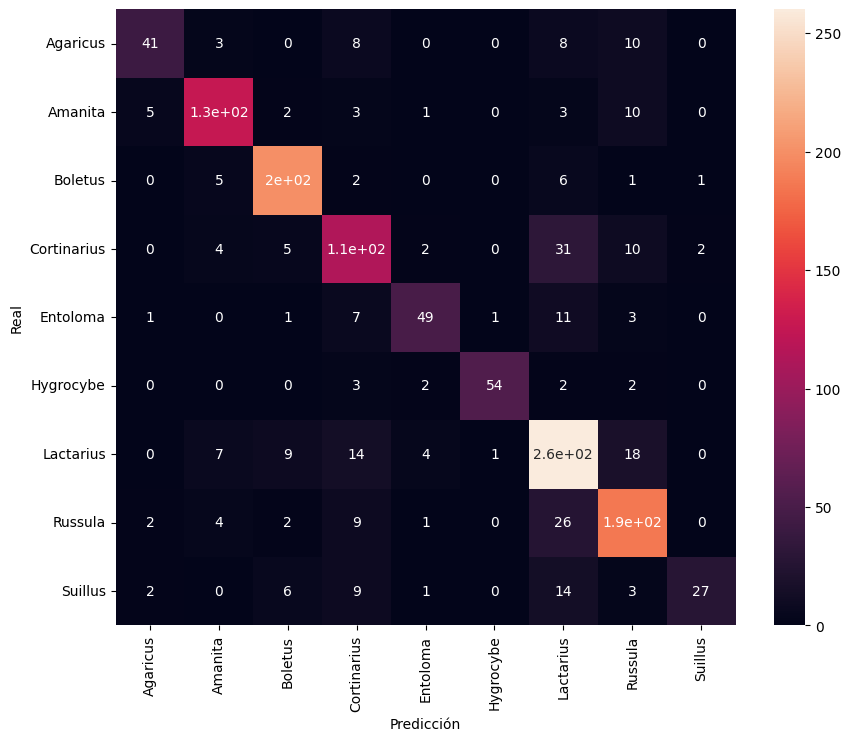

In [104]:
# Matriz de confusión Modelo 3

matriz_confusion_svm_3 = confusion_matrix(y_test_encoded, predicciones_svm_3)

# Visualizar Matriz de Confusión
plt.figure(figsize=(10, 8))
sns.heatmap(matriz_confusion_svm_3, annot=True, xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.show()

Luego responde las siguientes preguntas:
    
Del mejor clasificador SVM obtenido, ¿Que hiperparámetro puede haber favorecido a este SVM en este problema en particular?

Podemos ver que el modelo 3 es el que tiene un mejor rendimiento en las métricas de evaluación, al analizar el detalla de los hiperparámetros, podemos ver que el modelo 3 no tiene un kernel lineal como si lo tienen los modelos 1 y 2. Además, si vemos la comparación entre el modelo 1 y 2, entendemos que el hiperparámetro C no aporta de manera significativa al rendimiento del modelo, por lo que podemos inferir que el kernel no lineal es el que aporta de manera significativa al rendimiento del modelo 3.

---

# Actividad 4.2: Entrenamiento de un Clasificador MLP con Embeddings de Imágenes
Define nuevamente los mismos MLP utilizados en la pregunta 1.1.1. y entrenalos usando los embeddings generados por ResNet50 en el set de train.

In [108]:
modelo_1 = MLPClassifier(hidden_layer_sizes=(128, 128, 128), activation='relu', random_state=42)
modelo_1.fit(train_embeddings, y_train_encoded)

modelo_2 = MLPClassifier(hidden_layer_sizes=(256, 256, 256), activation='relu', random_state=42)
modelo_2.fit(train_embeddings, y_train_encoded)

modelo_3 = MLPClassifier(hidden_layer_sizes=(256, 256, 256, 256, 256), activation='relu', random_state=42)
modelo_3.fit(train_embeddings, y_train_encoded)


MLPClassifier(hidden_layer_sizes=(256, 256, 256, 256, 256), random_state=42)

Evalúa su rendimiento utilizando las métricas y decide cual es el mejor y genera su matriz de confusión.

In [114]:
predicciones_1 = modelo_1.predict(test_embeddings)
print("Modelo 1")
print(classification_report(y_test_encoded, predicciones_1, target_names=classes))

predicciones_2 = modelo_2.predict(test_embeddings)
print("Modelo 2")
print(classification_report(y_test_encoded, predicciones_2, target_names=classes))

predicciones_3 = modelo_3.predict(test_embeddings)
print("Modelo 3")
print(classification_report(y_test_encoded, predicciones_3, target_names=classes))

Modelo 1
              precision    recall  f1-score   support

    Agaricus       0.80      0.73      0.76        70
     Amanita       0.84      0.86      0.85       150
     Boletus       0.93      0.93      0.93       215
 Cortinarius       0.72      0.74      0.73       167
    Entoloma       0.69      0.66      0.67        73
   Hygrocybe       0.90      0.90      0.90        63
   Lactarius       0.79      0.81      0.80       313
     Russula       0.79      0.81      0.80       230
     Suillus       0.76      0.61      0.68        62

    accuracy                           0.81      1343
   macro avg       0.80      0.78      0.79      1343
weighted avg       0.81      0.81      0.81      1343

Modelo 2
              precision    recall  f1-score   support

    Agaricus       0.84      0.69      0.76        70
     Amanita       0.81      0.88      0.85       150
     Boletus       0.91      0.93      0.92       215
 Cortinarius       0.74      0.71      0.72       167
    En

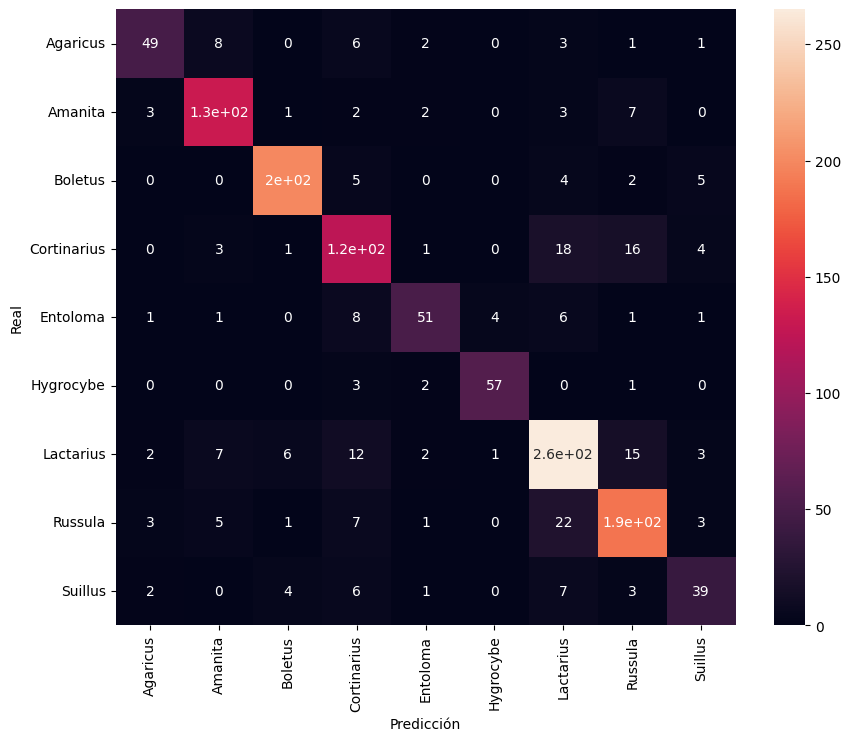

In [115]:
# Matriz de confusión Modelo 3
matriz_confusion_3 = confusion_matrix(y_test_encoded, predicciones_3)

# Visualizar Matriz de Confusión
plt.figure(figsize=(10, 8))
sns.heatmap(matriz_confusion_3, annot=True, xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.show()

Por último responde a las siguientes preguntas:
- ¿Qué modelo obtiene mejores resultados, MLP sobre las imágenes o MLP sobre los embeddings? ¿Reemplazar las imágenes por embeddings generó un aumento en el rendimiento del modelo? Independeiente de la respuesta anterior, ¿a qué puede deberse aquello?  Explica cómo la transformación de las imágenes en embeddings ayuda a los modelos a capturar mejor las características importantes y teorizan por qué un modelo podría beneficiarse más que otro de esta representación.
- ¿Cuál de los modelos (SVM o MLP) tuvo un mejor rendimiento al usar los embeddings de \texttt{ResNet50}?. ¿A qué se debe esto? Justifica tu respuesta considerando cómo cada modelo maneja las características de alta dimensionalidad y las ventajas que uno podría tener sobre el otro.

En primer lugar, podemos ver que el MLP obtiene considereblamente mejor rendimiento con embeddings que con imágenes. Es por esto que reemplazar las imágenes por embeddings generó un aumento en el rendimiento del modelo, esto se debe a que los embeddings permiten que el modelo pueda aprender de los datos de manera más simple, ya que se reduce la dimensionalidad de los datos y captura de manera más simple las características más importantes de los datos.

En particular, logramos ver que por una leve diferencia, el modelo SVM obtiene un mejor rendimiento al usar los embeddings de ResNet50, esto puede deberse a que el modelo SVM opera bien con redes de alta dimensionalidad, sin embargo para los valores seleccionados de hiperparámetros, no podemos inferir ninguna ventaja en particular ya que la ventaja es muy sutil y no se ha estudiado para una mayor cantidad de iteraciones y diferentes valores de hiperparámetros.